<a href="https://www.kaggle.com/code/dilekdd/telco-churn-project?scriptVersionId=202651318" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="text-align: center; font-size: 40px; font-weight: bold; color: hotpink;">
     Churn - Telecommunication
</div>


A machine learning model is expected to be developed to accurately predict which customers are at risk of leaving the company (churning).

Telco churn data includes information about an imaginary telecom company that provided home phone and Internet services to 7,043 customers in California in the third quarter. It shows which customers churned, stayed, or signed up for their service.

Data Dictionary

| **Feature**       | **Description**                                                                                       |
|-------------------|-------------------------------------------------------------------------------------------------------|
| CustomerId        | Customer's unique ID                                                                                  |
| Gender            | Gender of the customer                                                                                |
| SeniorCitizen     | Whether the customer is a senior citizen (1, 0)                                                       |
| Partner           | Whether the customer has a partner (Yes, No)                                                          |
| Dependents        | Whether the customer has dependents (Yes, No)                                                         |
| Tenure            | Number of months the customer has stayed with the company                                             |
| PhoneService      | Whether the customer has phone service (Yes, No)                                                      |
| MultipleLines     | Whether the customer has multiple lines (Yes, No, No phone service)                                   |
| InternetService   | Customer's internet service provider (DSL, Fiber optic, No)                                           |
| OnlineSecurity    | Whether the customer has online security (Yes, No, No internet service)                               |
| OnlineBackup      | Whether the customer has online backup (Yes, No, No internet service)                                 |
| DeviceProtection  | Whether the customer has device protection (Yes, No, No internet service)                             |
| TechSupport       | Whether the customer receives technical support (Yes, No, No internet service)                        |
| StreamingTV       | Whether the customer has streaming TV service (Yes, No, No internet service)                          |
| StreamingMovies   | Whether the customer has streaming movies service (Yes, No, No internet service)                      |
| Contract          | Length of the customer's contract (Month-to-month, One year, Two year)                                |
| PaperlessBilling  | Whether the customer has paperless billing (Yes, No)                                                  |
| PaymentMethod     | Customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)) |
| MonthlyCharges    | The amount charged to the customer monthly                                                            |
| TotalCharges      | The total amount charged to the customer                                                              |
| Churn             | Whether the customer churned (Yes, No)                                                                

In [1]:
#importing the required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report,  RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, validation_curve

import warnings
warnings.simplefilter(action="ignore")


In [2]:
#adjusting the display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.width', None)     
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#reading the dataset
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
#converting TotalCharges data type to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [6]:
#changing the representation of Churn variable
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

In [7]:
#converting SeniorCitizen to object type
df["SeniorCitizen"] = df["SeniorCitizen"].astype("object")

# Exploratory Data Analysis

In [8]:
#function for getting a summary of the dataset
def quick_summary(dataframe, head=2):
    print("##################### HEAD #####################")
    print(dataframe .head(head))
    print("##################### TAIL #####################")
    print(dataframe.tail(head))
    print("##################### SHAPE #####################")
    print(dataframe.shape)
    print("##################### MISSING VALUES #####################")
    print(dataframe.isnull().sum())
    print("##################### QUANTILES #####################")
    print(dataframe.describe().T)
    print("##################### INFO #####################")
    print(dataframe.info())
quick_summary(df)

##################### HEAD #####################
   customerID  gender SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female             0     Yes         No       1           No   
1  5575-GNVDE    Male             0      No         No      34          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   

  PaperlessBilling     PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0              Yes  Electronic check          29.850        29.850      0  
1               No      Mailed check          56.950      1889.500      0  
##################### TAIL #####################

# Identifying And Classifying The Variable Types

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optional
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)

cat_cols
num_cols
cat_but_car

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


['customerID']

In [10]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
df["Churn"].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [13]:
df['Churn'].value_counts(normalize=True) * 100 # #imbalanced distribution

Churn
0   73.463
1   26.537
Name: proportion, dtype: float64

# Categorical Variable Analysis

        gender  Ratio
gender               
Male      3555 50.476
Female    3488 49.524
##########################################


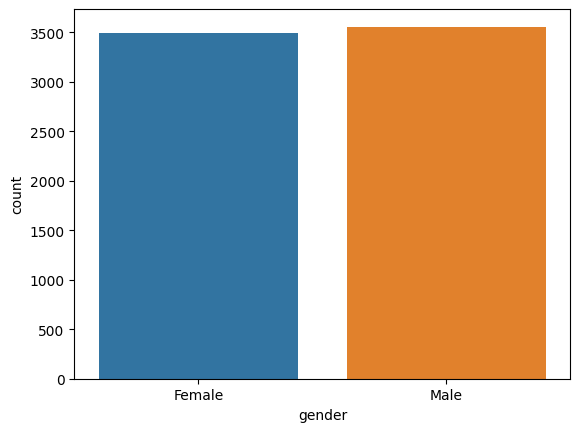

               SeniorCitizen  Ratio
SeniorCitizen                      
0                       5901 83.785
1                       1142 16.215
##########################################


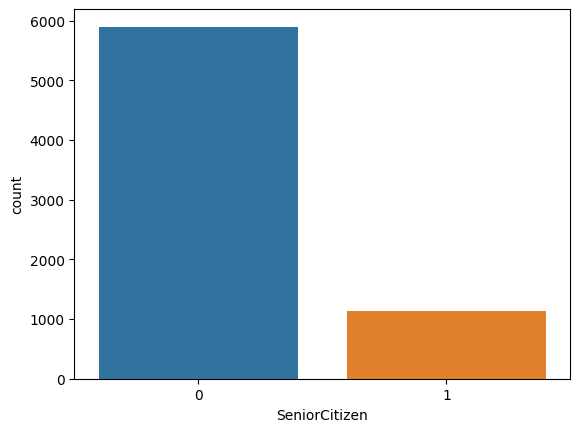

         Partner  Ratio
Partner                
No          3641 51.697
Yes         3402 48.303
##########################################


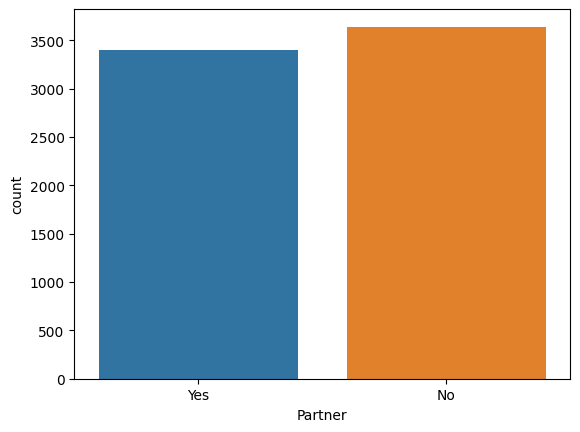

            Dependents  Ratio
Dependents                   
No                4933 70.041
Yes               2110 29.959
##########################################


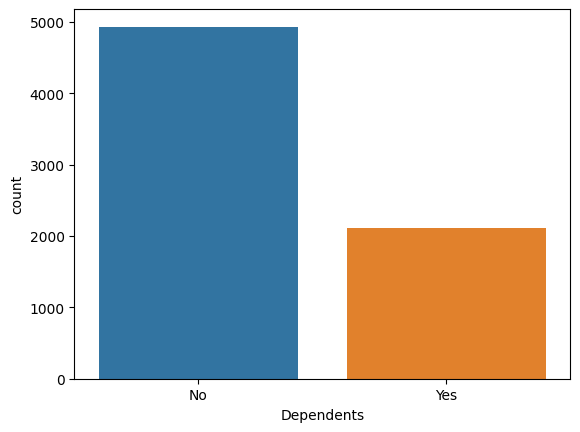

              PhoneService  Ratio
PhoneService                     
Yes                   6361 90.317
No                     682  9.683
##########################################


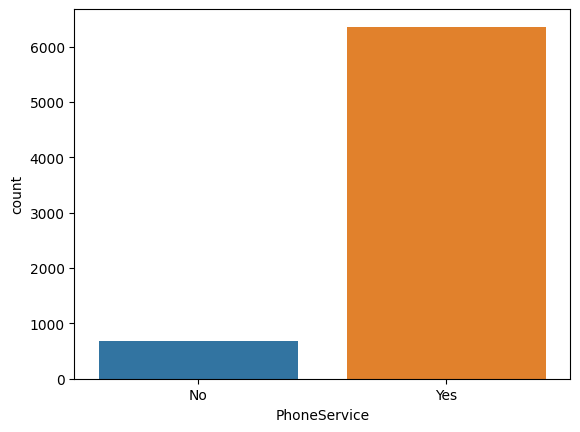

                  MultipleLines  Ratio
MultipleLines                         
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683
##########################################


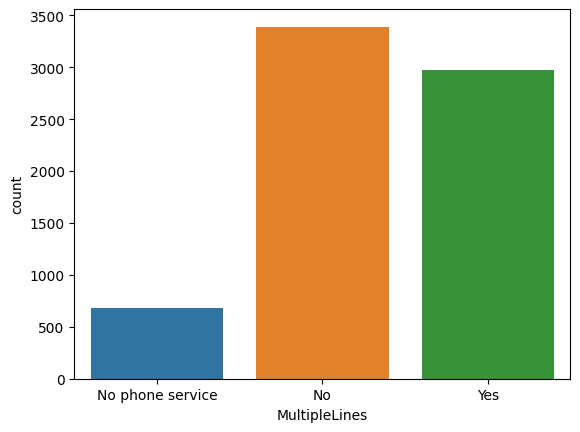

                 InternetService  Ratio
InternetService                        
Fiber optic                 3096 43.959
DSL                         2421 34.375
No                          1526 21.667
##########################################


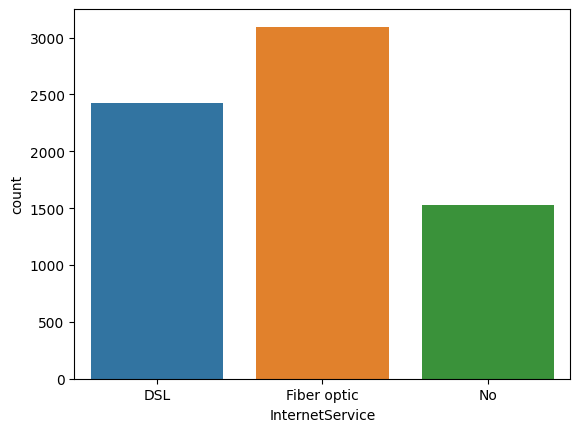

                     OnlineSecurity  Ratio
OnlineSecurity                            
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667
##########################################


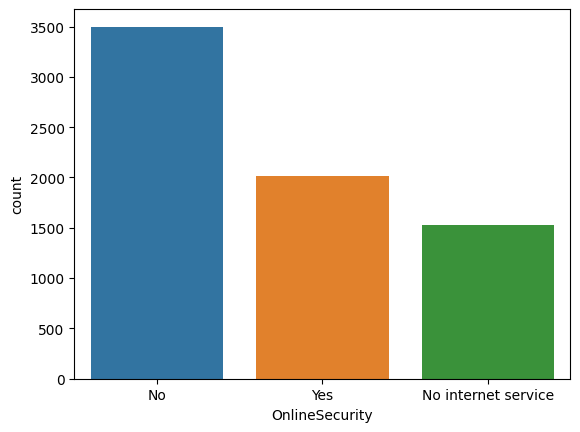

                     OnlineBackup  Ratio
OnlineBackup                            
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667
##########################################


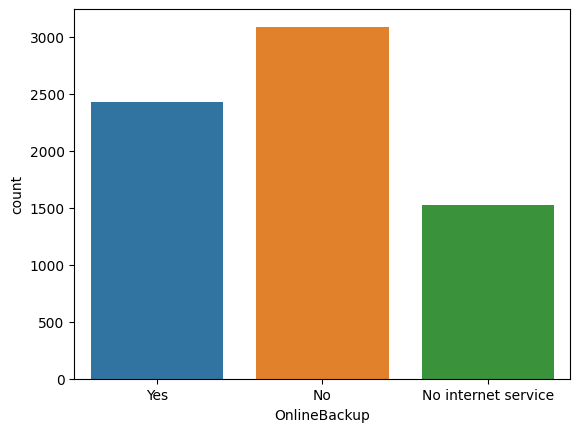

                     DeviceProtection  Ratio
DeviceProtection                            
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667
##########################################


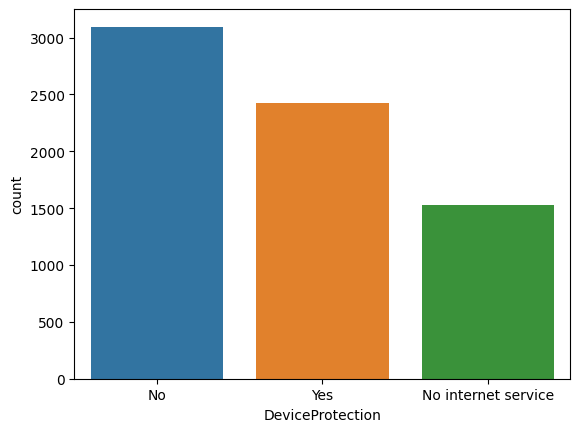

                     TechSupport  Ratio
TechSupport                            
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667
##########################################


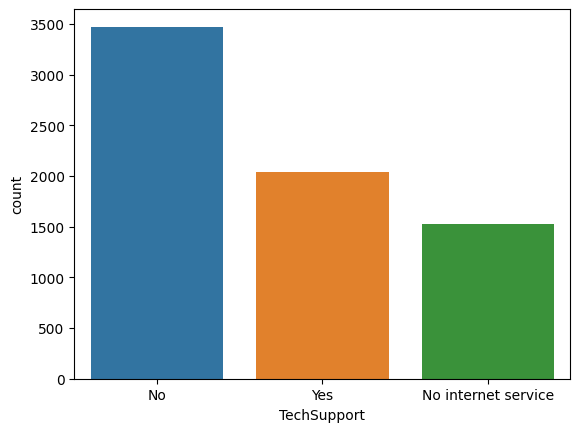

                     StreamingTV  Ratio
StreamingTV                            
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667
##########################################


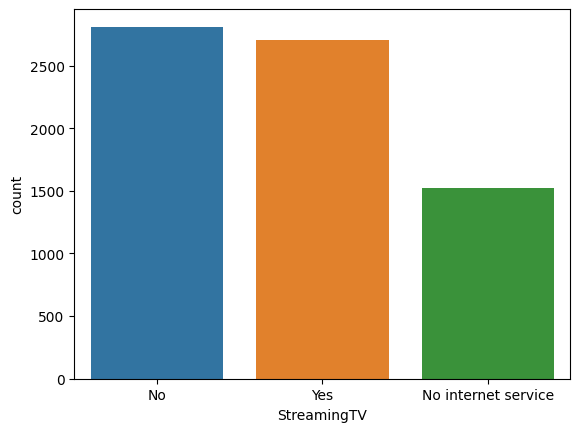

                     StreamingMovies  Ratio
StreamingMovies                            
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667
##########################################


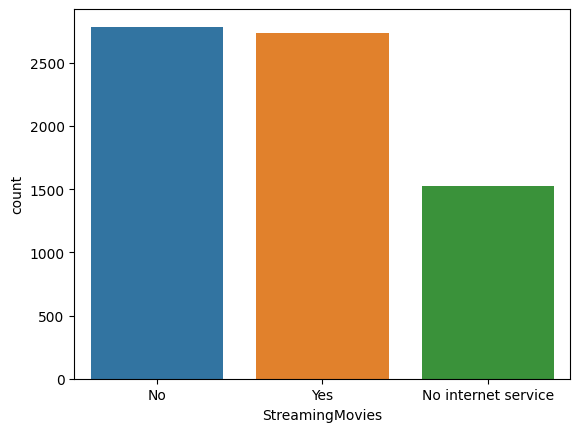

                Contract  Ratio
Contract                       
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914
##########################################


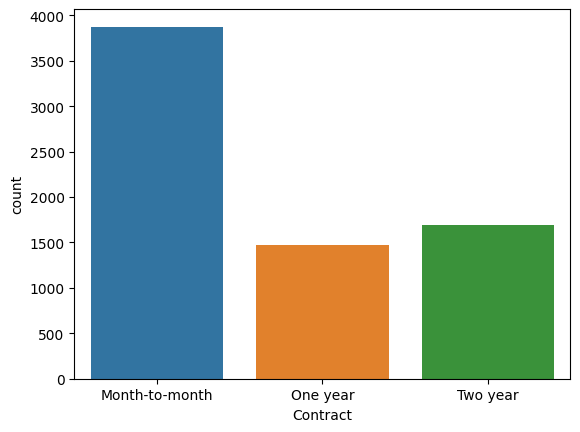

                  PaperlessBilling  Ratio
PaperlessBilling                         
Yes                           4171 59.222
No                            2872 40.778
##########################################


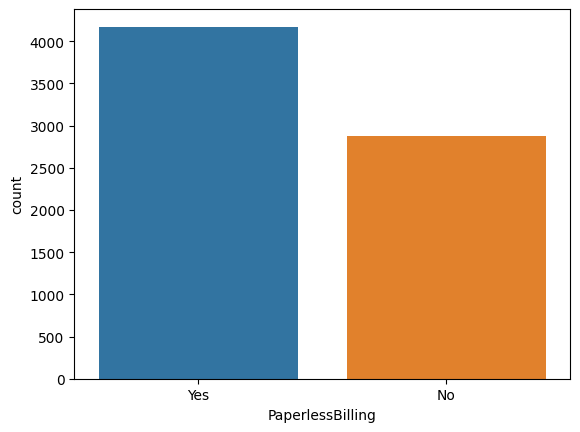

                           PaymentMethod  Ratio
PaymentMethod                                  
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610
##########################################


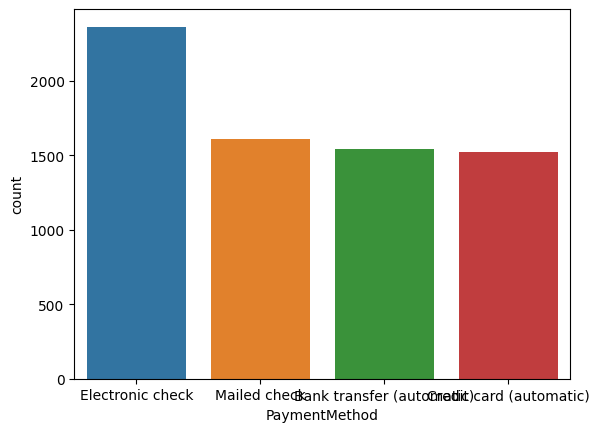

       Churn  Ratio
Churn              
0       5174 73.463
1       1869 26.537
##########################################


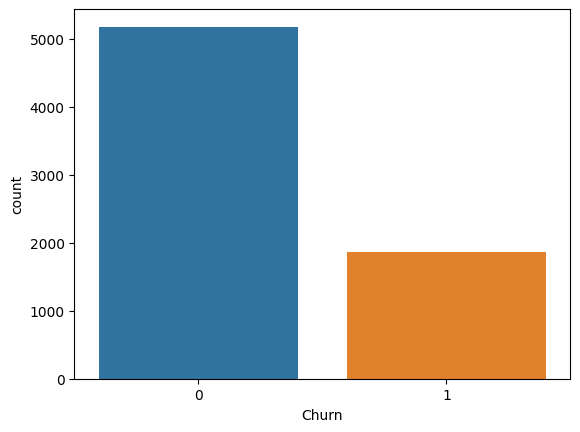

In [14]:
#summarising the categorical variables
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

# Kategorik kolonlar için fonksiyonu çalıştırma
for col in cat_cols:
    cat_summary(df, col, plot=True)

* Approximately half of the customers in our dataset are male, and the other half are female.
* About 50% of the customers have a partner (married).
* Only 30% of the total customers have dependents.
* 90% of the customers receive phone service.
* Of the 90% who receive phone service, 53% do not have multiple lines.
* 21% of the customers do not have an internet service provider.
* Most customers have month-to-month contracts. There are a similar number of customers with 1-year and 2-year contracts.
* 60% of the customers have paperless billing.
* Approximately 26% of the customers left the platform last month.
* 16% of the dataset consists of senior customers. Therefore, most of the customers in the data are younger.

# Numerical Variable Analysis

count   7043.000
mean      32.371
std       24.559
min        0.000
5%         1.000
10%        2.000
20%        6.000
30%       12.000
40%       20.000
50%       29.000
60%       40.000
70%       50.000
80%       60.000
90%       69.000
95%       72.000
99%       72.000
max       72.000
Name: tenure, dtype: float64


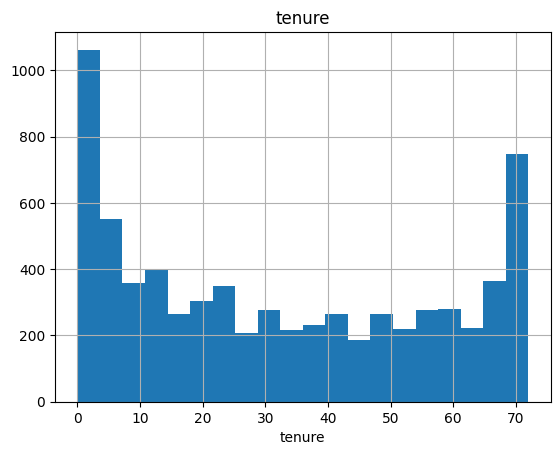

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
20%       25.050
30%       45.850
40%       58.830
50%       70.350
60%       79.100
70%       85.500
80%       94.250
90%      102.600
95%      107.400
99%      114.729
max      118.750
Name: MonthlyCharges, dtype: float64


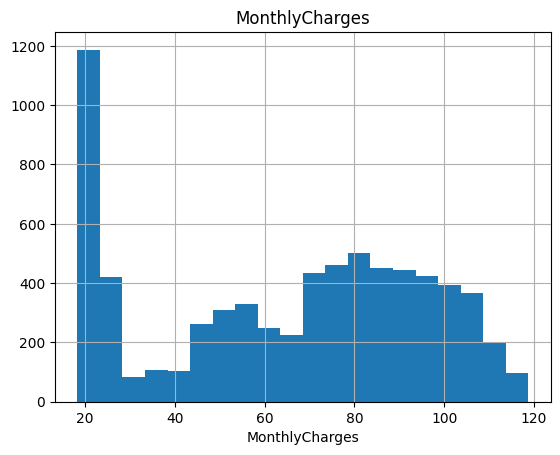

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
20%      267.070
30%      551.995
40%      944.170
50%     1397.475
60%     2048.950
70%     3141.130
80%     4475.410
90%     5976.640
95%     6923.590
99%     8039.883
max     8684.800
Name: TotalCharges, dtype: float64


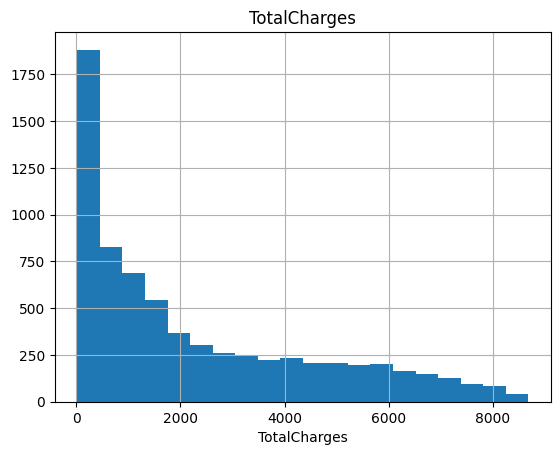

In [15]:
#summarising the numerical variables
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

for col in num_cols:
    num_summary(df, col, plot=True)

* When we look at Tenure, we see that there are many 1-month customers, followed by 70-month customers.

# Analysis of Categorical Variables By Target

In [16]:
#checking the details of target variable relations with categorical variables
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)


gender
        TARGET_MEAN  Count  Ratio
gender                           
Female        0.269   3488 49.524
Male          0.262   3555 50.476


SeniorCitizen
               TARGET_MEAN  Count  Ratio
SeniorCitizen                           
0                    0.236   5901 83.785
1                    0.417   1142 16.215


Partner
         TARGET_MEAN  Count  Ratio
Partner                           
No             0.330   3641 51.697
Yes            0.197   3402 48.303


Dependents
            TARGET_MEAN  Count  Ratio
Dependents                           
No                0.313   4933 70.041
Yes               0.155   2110 29.959


PhoneService
              TARGET_MEAN  Count  Ratio
PhoneService                           
No                  0.249    682  9.683
Yes                 0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
MultipleLines                              
No                      0.250   3390 48.133
No phone service        0.249    682  9

* The churn percentage is almost equal between male and female customers.
* Customers with a partner and dependents have a lower churn rate.
* There is no difference in churn rate between those with PhoneService and MultipleLines.
* Customers with Fiber Optic Internet Service have a significantly higher churn rate.
* Customers without services like OnlineSecurity, OnlineBackup, and TechSupport have a higher churn rate.
* A larger percentage of customers with monthly subscriptions churn compared to those with one or two-year contracts.
* Customers with paperless billing have a higher churn rate.
* Customers using the ElectronicCheck payment method tend to leave the platform more than those using other methods.
* Senior customers have a higher churn percentage.

# Analysis of Numerical Variables By Target

In [17]:
#target variable with numerical variables
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       tenure
Churn        
0      37.570
1      17.979


       MonthlyCharges
Churn                
0              61.265
1              74.441


       TotalCharges
Churn              
0          2555.344
1          1531.796




When we look at the relationship between Tenure and Churn, we see that non-churn customers have been customers for longer periods of time
When monthlycharges and Churn are examined, churn customers have higher average monthly payments

# Correlation Analysis

In [18]:
#calling the grab_col_names function
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


['tenure', 'MonthlyCharges', 'TotalCharges']

In [19]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


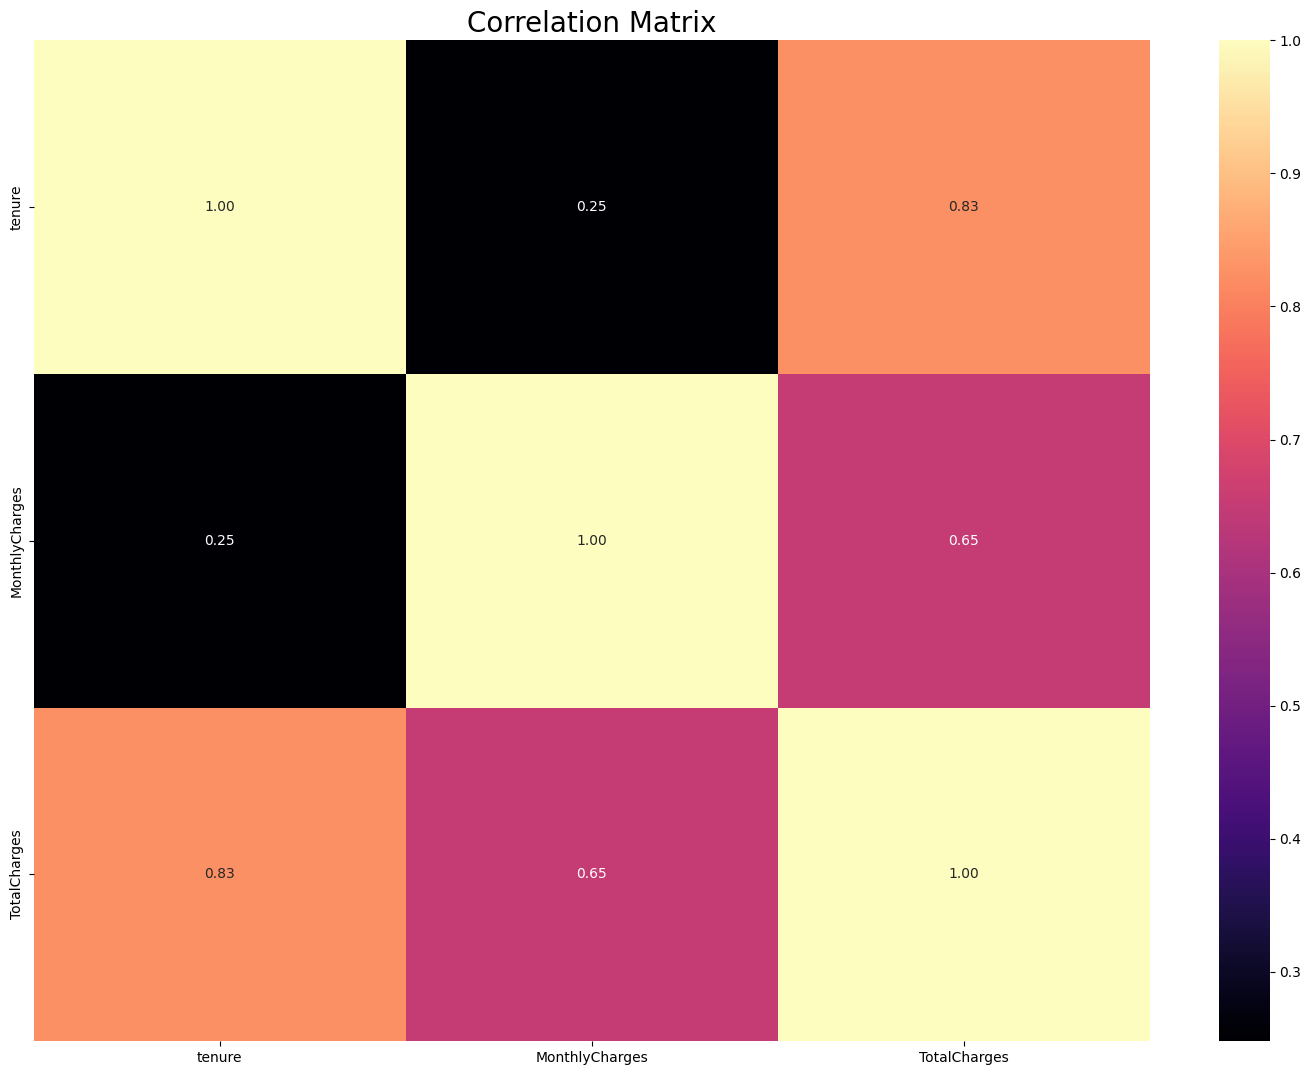

MonthlyCharges    0.193
TotalCharges     -0.199
tenure           -0.352
dtype: float64

In [20]:
df[num_cols].corr()

# Plot the Correlation Matrix
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# TotalChargers'in aylık ücretler ve tenure ile yüksek korelasyonlu olduğu görülmekte
df[num_cols].corrwith(df["Churn"]).sort_values(ascending=False)

TotalChargers appears to have high correlation with monthly fees and tenure

# Feature Engineeering

# Missing Values Analysis

In [21]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [22]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

              n_miss  ratio
TotalCharges      11  0.160


In [23]:
#df.drop(df[df["TotalCharges"].isnull()].index, axis=0)


# df[df["TotalCharges"].isnull()]["TotalCharges"] = df[df["TotalCharges"].isnull()]["MonthlyCharges"]

df.iloc[df[df["TotalCharges"].isnull()].index,19] = df[df["TotalCharges"].isnull()]["MonthlyCharges"]

# TotalCharges direkt sıfıra eşitleyebiliriz.

In [24]:
df["tenure"] = df["tenure"] + 1
df[df["tenure"]==1]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,1,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.550,52.550,0
753,3115-CZMZD,Male,0,No,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.250,20.250,0
936,5709-LVOEQ,Female,0,Yes,Yes,1,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.850,80.850,0
1082,4367-NUYAO,Male,0,Yes,Yes,1,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.750,25.750,0
1340,1371-DWPAZ,Female,0,Yes,Yes,1,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.050,56.050,0
3331,7644-OMVMY,Male,0,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.850,19.850,0
3826,3213-VVOLG,Male,0,Yes,Yes,1,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.350,25.350,0
4380,2520-SGTTA,Female,0,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.000,20.000,0
5218,2923-ARZLG,Male,0,Yes,Yes,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.700,19.700,0
6670,4075-WKNIU,Female,0,Yes,Yes,1,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.350,73.350,0


# Outlier Analysis

In [25]:
#function for defining outlier threshold
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

#replacing the outliers
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


#checking to see if there is outliers 
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


# for col in num_cols:
#     replace_with_thresholds(df, col)

#applying the check_outlier function to all num_cols
for col in num_cols:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

tenure False
MonthlyCharges False
TotalCharges False


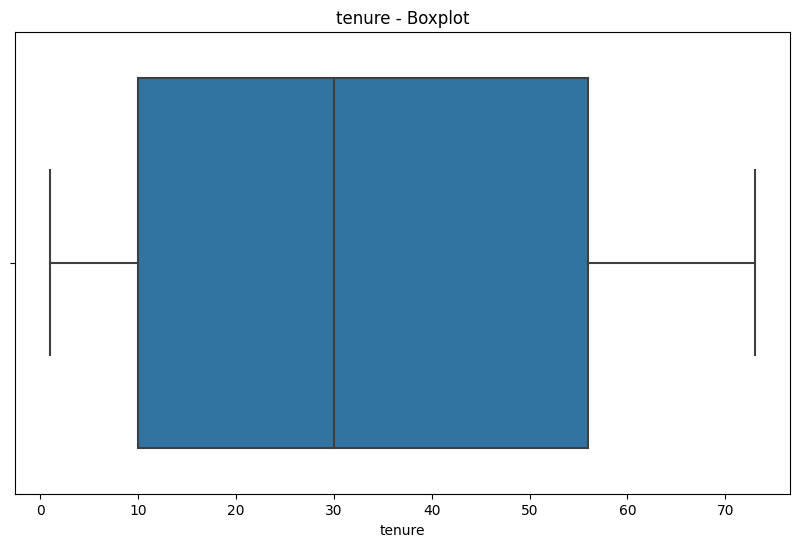

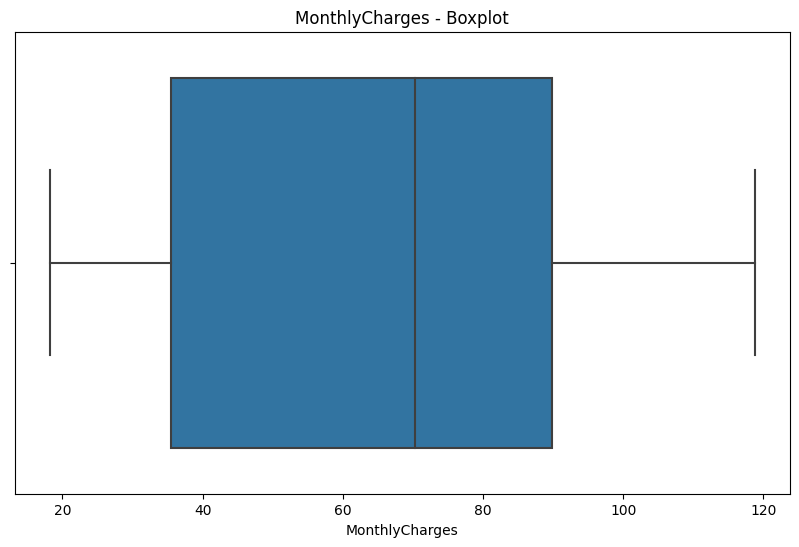

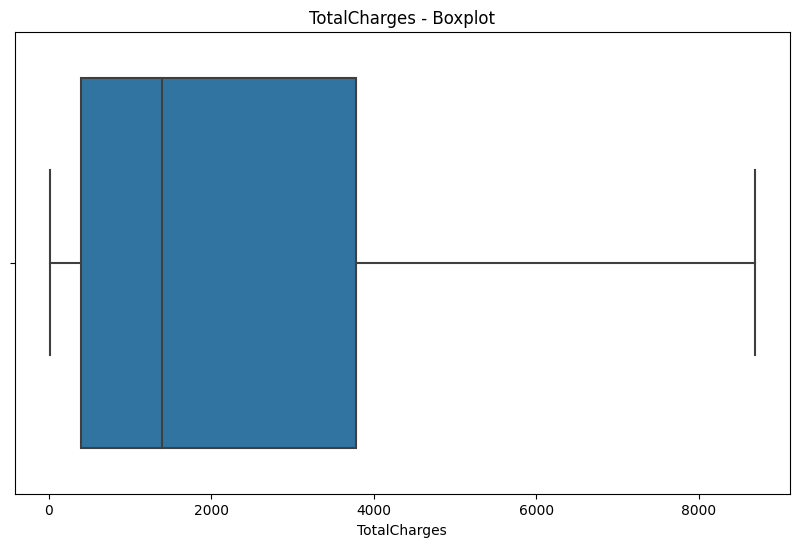

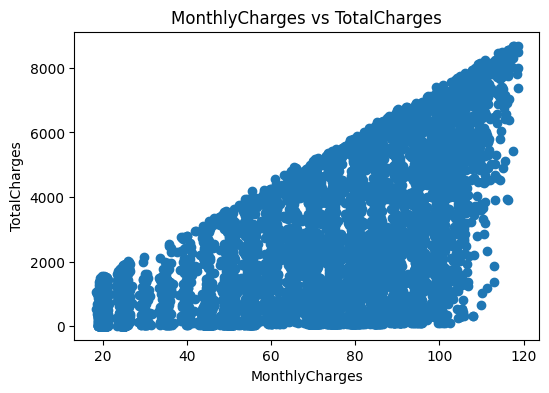

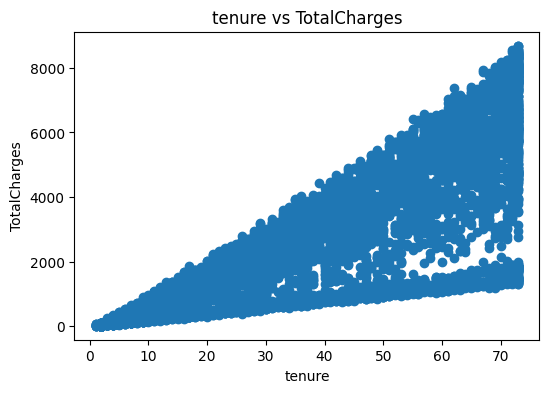

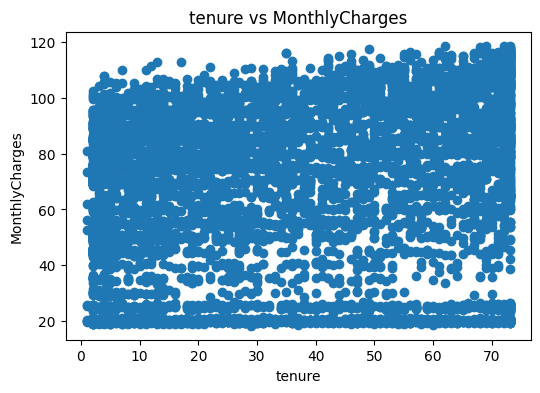

In [26]:
#plots to see the distribution of num_cols

for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.title(f"{col} - Boxplot")
    plt.show()



plt.figure(figsize=(6, 4))
plt.scatter(df['MonthlyCharges'], df['TotalCharges'])
plt.title('MonthlyCharges vs TotalCharges')
plt.xlabel('MonthlyCharges')
plt.ylabel('TotalCharges')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(df['tenure'], df['TotalCharges'])
plt.title('tenure vs TotalCharges')
plt.xlabel('tenure')
plt.ylabel('TotalCharges')
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(df['tenure'], df['MonthlyCharges'])
plt.title('tenure vs MonthlyCharges')
plt.xlabel('tenure')
plt.ylabel('MonthlyCharges')
plt.show()

In [27]:
#showing the number and percentage of missing values in each of the columns that has missing values
#returns missing values' column names
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

na_cols = missing_values_table(df, True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [28]:
#calling the grab_col_names function
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


In [29]:
# #using get_dummmies method before imputing the missing values
# from sklearn.impute import KNNImputer
# dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)
# scaler = MinMaxScaler()
# dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)
# imputer = KNNImputer(n_neighbors=5)
# dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)
# dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)
# df["TotalCharges"] = dff["TotalCharges"]
# df["TotalCharges"].isnull().sum()
# dff.head()

# Base Model

In [30]:
#copying the dataset and creating a new one
df_base = df.copy()

In [31]:
#calling out the grab_col_names with df_base dataframe 
cat_cols, num_cols, cat_but_car = grab_col_names(df_base)
cat_cols = [col for col in cat_cols if col not in ["Churn"]]


Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1


In [32]:
#applying One Hot Encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
    return dataframe

df_base = one_hot_encoder(df_base, cat_cols)

In [33]:
df_base.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,2,29.850,29.850,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,5575-GNVDE,35,56.950,1889.500,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,3668-QPYBK,3,53.850,108.150,1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,7795-CFOCW,46,42.300,1840.750,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,9237-HQITU,3,70.700,151.650,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [34]:
#scaling the num_cols
rs = RobustScaler()
df_base[num_cols] = rs.fit_transform(df_base[num_cols])
df_base.describe().T
df_base.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,-0.609,-0.745,-0.403,0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,5575-GNVDE,0.109,-0.247,0.146,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1
2,3668-QPYBK,-0.587,-0.304,-0.380,1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,7795-CFOCW,0.348,-0.516,0.132,0,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0
4,9237-HQITU,-0.587,0.006,-0.367,1,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0


In [35]:
#establishing the model
y = df_base["Churn"]
X = df_base.drop(["Churn", "customerID"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=24689)

X_train.shape
X_test.shape

models = [('LR', LogisticRegression(random_state=24689, max_iter=1500)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=24689)),
          ('RF', RandomForestClassifier(random_state=24689)),
          ('XGB', XGBClassifier(random_state=24689)),
          ("LightGBM", LGBMClassifier(random_state=24689, force_col_wise=True)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=24689))]

# a list that we can store the performance results of the model
results = []

# creating a for loop on models
for model_name, model in models:
    # training the model 
    model.fit(X_train, y_train)

    # prediction on Test dataset 
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  

    # calculating the metrics 
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # stroring the results 
    results.append({
        'Model':  model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    })

# converting the results' list to a dataframe 
import pandas as pd

result_df = pd.DataFrame(results)
result_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1482, number of negative: 4152
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263046 -> initscore=-1.030198
[LightGBM] [Info] Start training from score -1.030198


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,LR,0.806,0.690,0.535,0.603,0.854
1,KNN,0.751,0.551,0.506,0.528,0.781
2,CART,0.740,0.525,0.548,0.536,0.683
3,RF,0.785,0.639,0.499,0.560,0.835
4,XGB,0.789,0.639,0.527,0.578,0.838
5,LightGBM,0.801,0.677,0.525,0.591,0.850
6,CatBoost,0.806,0.704,0.509,0.591,0.855


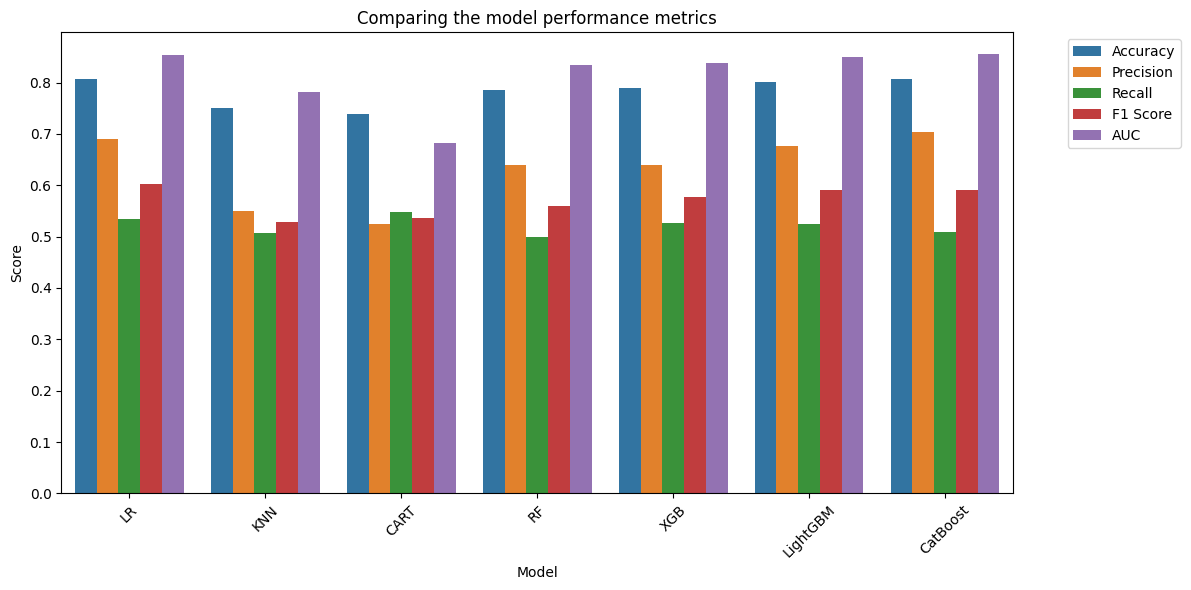

In [36]:
#plotting the performance metrics
import matplotlib.pyplot as plt
import seaborn as sns

# transforming the results_df by using 'Model' column
result_melt = result_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# adjusting the graph size 
plt.figure(figsize=(12, 6))

# Visualizing performance metrics with Seaborn barplot
sns.barplot(x="Model", y="Value", hue="Metric", data=result_melt)

# Header and the labels 
plt.title("Comparing the model performance metrics")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)  # adjusting the Legend position
plt.tight_layout()

# plotting
plt.show()

Feature Importance for LR:
LogisticRegression does not have feature_importances_ attribute
Feature Importance for KNN:
KNeighborsClassifier does not have feature_importances_ attribute
Feature Importance for CART:


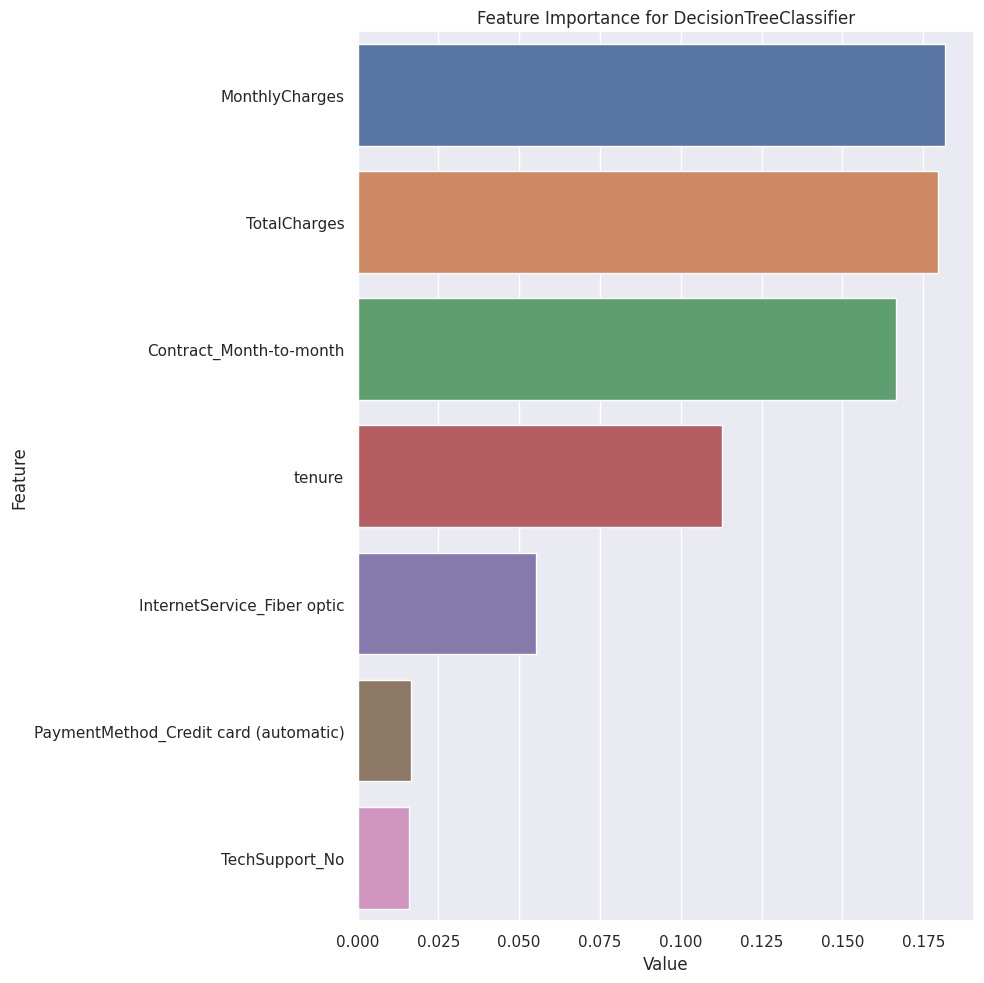

Feature Importance for RF:


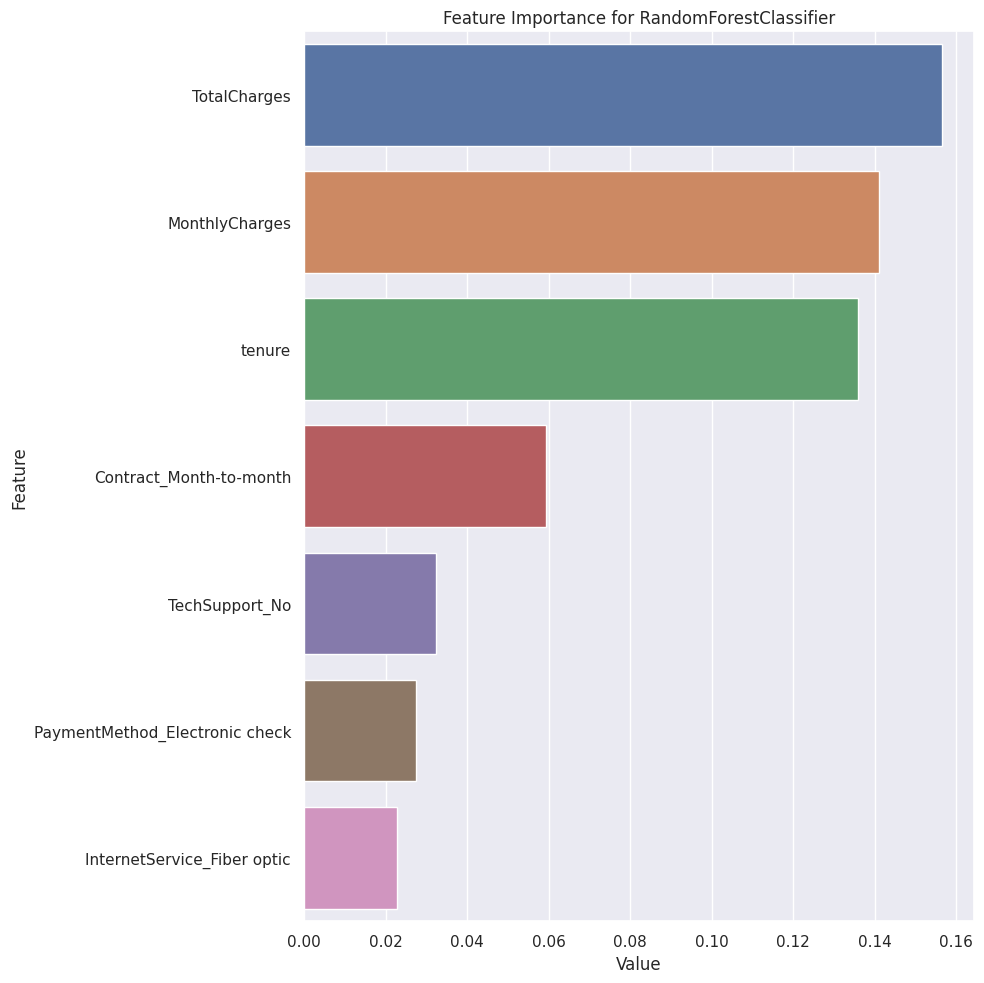

Feature Importance for XGB:


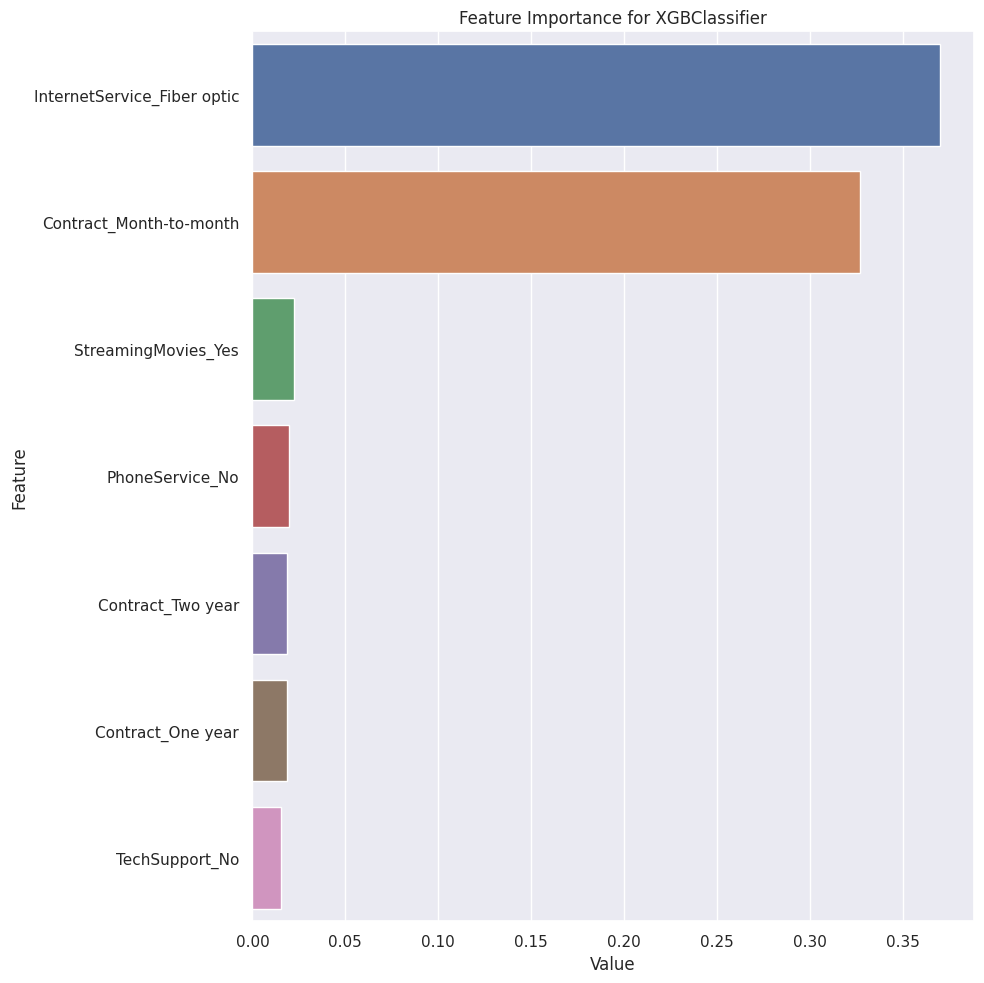

Feature Importance for LightGBM:


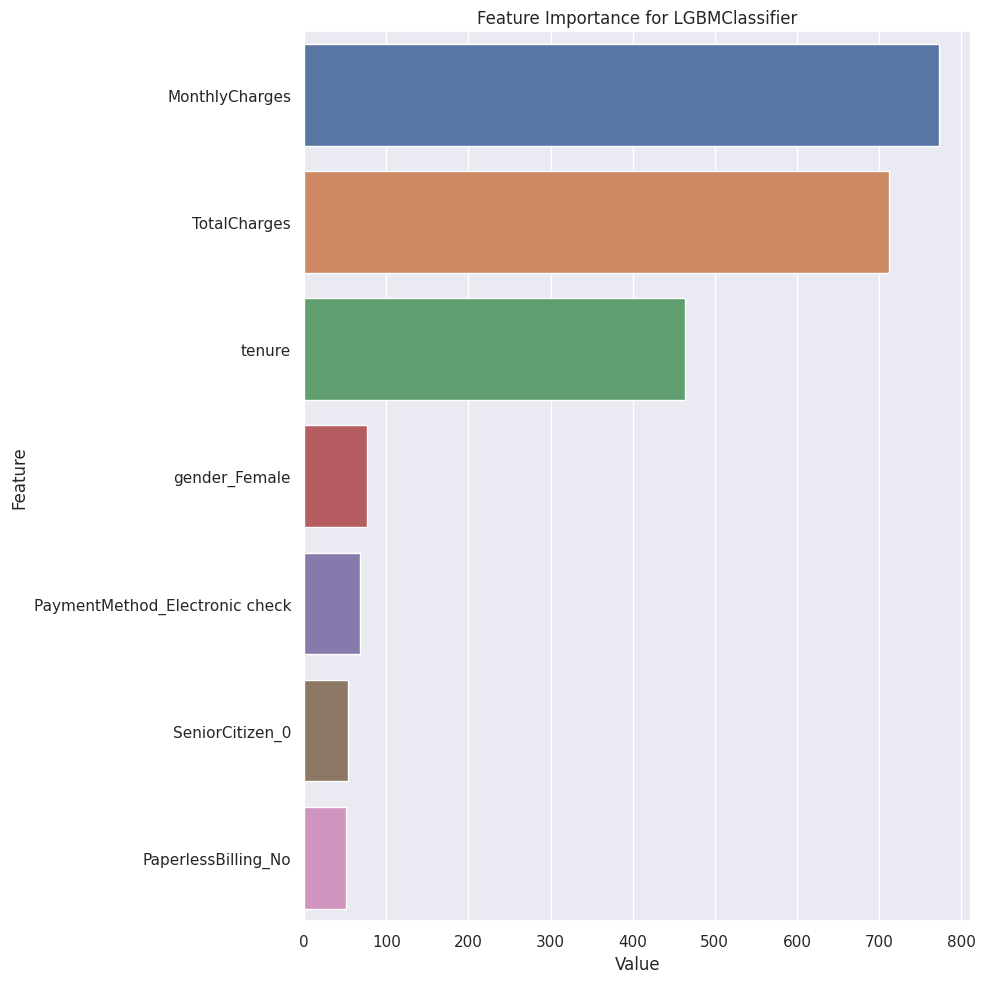

Feature Importance for CatBoost:


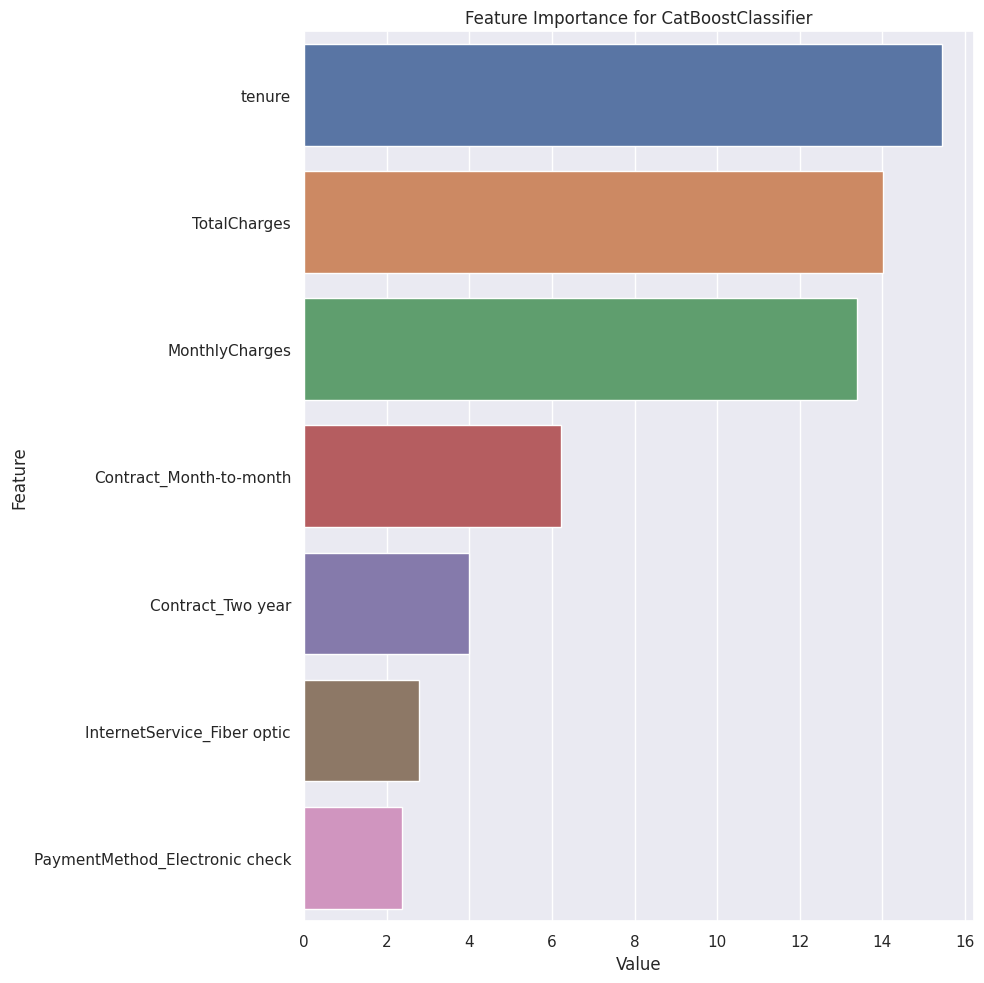

In [37]:
# function for plotting the feature importance graphs 
def plot_importance(model, features, num=len(X_train.columns), save=False):
    if hasattr(model, 'feature_importances_'):  # checking to see if the model has a feature impportance feature
        feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
        plt.title(f'Feature Importance for {type(model).__name__}')
        plt.tight_layout()
        plt.show()
        if save:
            plt.savefig(f'{type(model).__name__}_importances.png')
    else:
        print(f"{type(model).__name__} does not have feature_importances_ attribute")

# creating a loop over models 
for model_name, model in models:
    # plotting only for the models that support feature_importance feature 
    print(f"Feature Importance for {model_name}:")
    plot_importance(model, X_train, num=7)

# Deriving New Features

In [38]:
#checking the max vale of tenure variable
df["tenure"].max()

73

In [39]:
# Create a yearly categorical variable from the 'tenure' variable
df.loc[(df["tenure"] >= 0) & (df["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"] > 12) & (df["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"] > 24) & (df["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"] > 36) & (df["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"] > 48) & (df["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"] > 60) & (df["tenure"] <= 73), "NEW_TENURE_YEAR"] = "5-6 Year"

# Label customers with a 1 or 2-year contract as 'Engaged'
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year", "Two year"] else 0)

# Identify customers who have no support, backup, or protection services
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or 
                            (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

# Identify customers with a monthly contract who are young (not senior)
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and 
                                       (x["SeniorCitizen"] == 0) else 0, axis=1)

# Calculate the total number of services the customer has
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                               'OnlineBackup', 'DeviceProtection', 'TechSupport',
                               'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

# Identify customers who use any streaming service
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or 
                                        (x["StreamingMovies"] == "Yes") else 0, axis=1)

# Identify if a customer uses automatic payment methods
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in 
                                                       ["Bank transfer (automatic)", "Credit card (automatic)"] else 0)

# Calculate the average monthly payment
df["NEW_AVG_Charges"] = df["TotalCharges"] / df["tenure"]

# Calculate the increase in the current price compared to the average price
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

# Calculate the service fee per service
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [40]:
#re-calling grab_col_names function and excluding the target variable from cat_cols
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 7


In [41]:
cat_cols = [col for col in cat_cols if col not in ["Churn"]]
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_TotalServices',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment']

In [42]:
#creating label encoder function
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling']

In [43]:
#applying the function for binary_cols
for col in binary_cols:
    df = label_encoder(df, col)

In [44]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,0,0,1,0,2,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,14.925,0.500,14.925
1,5575-GNVDE,1,0,0,0,35,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,53.986,0.948,14.238
2,3668-QPYBK,1,0,0,0,3,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,36.050,0.669,13.463
3,7795-CFOCW,1,0,0,0,46,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.016,0.946,10.575
4,9237-HQITU,0,0,0,0,3,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,50.550,0.715,35.350


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customerID              7043 non-null   object 
 1   gender                  7043 non-null   int64  
 2   SeniorCitizen           7043 non-null   int64  
 3   Partner                 7043 non-null   int64  
 4   Dependents              7043 non-null   int64  
 5   tenure                  7043 non-null   int64  
 6   PhoneService            7043 non-null   int64  
 7   MultipleLines           7043 non-null   object 
 8   InternetService         7043 non-null   object 
 9   OnlineSecurity          7043 non-null   object 
 10  OnlineBackup            7043 non-null   object 
 11  DeviceProtection        7043 non-null   object 
 12  TechSupport             7043 non-null   object 
 13  StreamingTV             7043 non-null   object 
 14  StreamingMovies         7043 non-null   

In [46]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 13


In [47]:
#excluding target "Churn", and "New_TotalServices" variables from cat_cols
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "New_TotalServices"]]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_TotalServices',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment']

In [48]:
#applying One Hot Encoder
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
    return dataframe

df = one_hot_encoder(df, cat_cols)

In [49]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_0-1 Year,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,NEW_Engaged_0,NEW_Engaged_1,NEW_noProt_0,NEW_noProt_1,NEW_Young_Not_Engaged_0,NEW_Young_Not_Engaged_1,NEW_TotalServices_0,NEW_TotalServices_1,NEW_TotalServices_2,NEW_TotalServices_3,NEW_TotalServices_4,NEW_TotalServices_5,NEW_TotalServices_6,NEW_TotalServices_7,NEW_FLAG_ANY_STREAMING_0,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_0,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,0,1,0,2,0,1,29.850,29.850,0,14.925,0.500,14.925,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,1,0,0,0,35,1,0,56.950,1889.500,0,53.986,0.948,14.238,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,3668-QPYBK,1,0,0,0,3,1,1,53.850,108.150,1,36.050,0.669,13.463,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0
3,7795-CFOCW,1,0,0,0,46,0,0,42.300,1840.750,0,40.016,0.946,10.575,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1
4,9237-HQITU,0,0,0,0,3,1,1,70.700,151.650,1,50.550,0.715,35.350,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0


In [50]:
#running the function grab_col_names
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 69
cat_cols: 62
num_cols: 6
cat_but_car: 1
num_but_cat: 62


In [51]:
#scaling the num_cols
rs = RobustScaler()
df[num_cols] = rs.fit_transform(df[num_cols])

In [52]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_0-1 Year,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,NEW_Engaged_0,NEW_Engaged_1,NEW_noProt_0,NEW_noProt_1,NEW_Young_Not_Engaged_0,NEW_Young_Not_Engaged_1,NEW_TotalServices_0,NEW_TotalServices_1,NEW_TotalServices_2,NEW_TotalServices_3,NEW_TotalServices_4,NEW_TotalServices_5,NEW_TotalServices_6,NEW_TotalServices_7,NEW_FLAG_ANY_STREAMING_0,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_0,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,0,1,0,-0.609,0,1,-0.745,-0.403,0,-0.786,-4.604,-0.061,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,1,0,0,0,0.109,1,0,-0.247,0.146,0,-0.120,-0.110,-0.136,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0
2,3668-QPYBK,1,0,0,0,-0.587,1,1,-0.304,-0.380,1,-0.426,-2.904,-0.221,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0
3,7795-CFOCW,1,0,0,0,0.348,0,0,-0.516,0.132,0,-0.358,-0.129,-0.537,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1
4,9237-HQITU,0,0,0,0,-0.587,1,1,0.006,-0.367,1,-0.179,-2.447,2.172,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0


<div style="text-align: center; font-size: 18px; font-weight: bold; color: purple;">
     Modelling
</div>

In [53]:
#dividing the dataset in two, establishing the model
y = df["Churn"]
X = df.drop(["Churn", "customerID"], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=24689)

X_train.shape
X_test.shape

X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

models = [('LR', LogisticRegression(random_state=24689, max_iter=1500)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=24689)),
          ('RF', RandomForestClassifier(random_state=24689)),
          ('XGB', XGBClassifier(random_state=24689)),
          ("LightGBM", LGBMClassifier(random_state=24689, force_row_wise=True)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=24689))]

# the list that we will store the the performance metrics of the model we are trying
results_new = []

# loop on the models' list
for model_name, model in models:
    # training the model
    model.fit(X_train, y_train)

    # prediction on the Test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  

    # calculating the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # storing the metrics
    results_new.append({
        'Model':  model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    })

# converting the results to a DataFrame 
import pandas as pd
result_new_df = pd.DataFrame(results_new)
result_new_df

[LightGBM] [Info] Number of positive: 1482, number of negative: 4152
[LightGBM] [Info] Total Bins 1470
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263046 -> initscore=-1.030198
[LightGBM] [Info] Start training from score -1.030198


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,LR,0.807,0.700,0.519,0.596,0.861
1,KNN,0.762,0.573,0.519,0.545,0.791
2,CART,0.742,0.529,0.543,0.536,0.684
3,RF,0.791,0.653,0.506,0.571,0.834
4,XGB,0.791,0.650,0.522,0.579,0.841
5,LightGBM,0.795,0.666,0.509,0.577,0.846
6,CatBoost,0.799,0.682,0.504,0.579,0.854


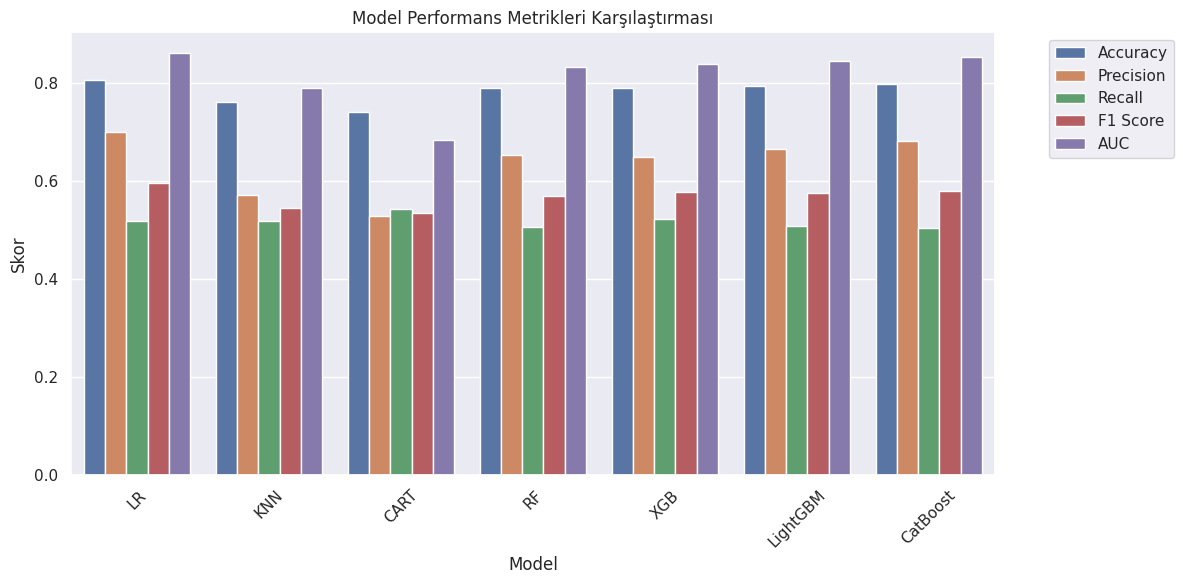

In [54]:
#plotting the comparison graph of the metrics
import matplotlib.pyplot as plt
import seaborn as sns

# transforming result_new_df DataFrame using the "Model" column
result_melt_ = result_new_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

# adjusting the graph
plt.figure(figsize=(12, 6))

# barplot settings
sns.barplot(x="Model", y="Value", hue="Metric", data=result_melt_)

# header and the labels
plt.title("Model Performans Metrikleri Karşılaştırması")
plt.ylabel("Skor")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2) #adjusting the explanation's position
plt.tight_layout()

# showing the plot
plt.show()

Feature Importance for LR:
LogisticRegression does not have feature_importances_ attribute
Feature Importance for KNN:
KNeighborsClassifier does not have feature_importances_ attribute
Feature Importance for CART:


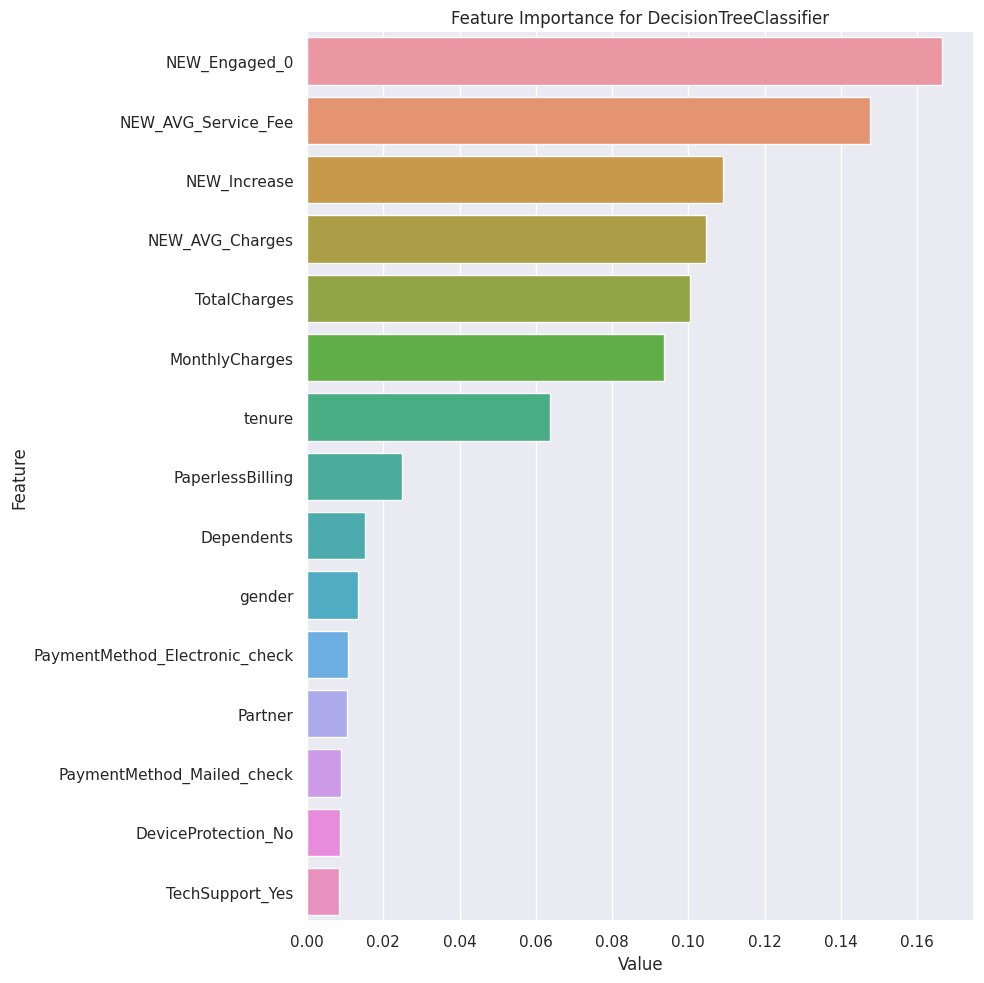

Feature Importance for RF:


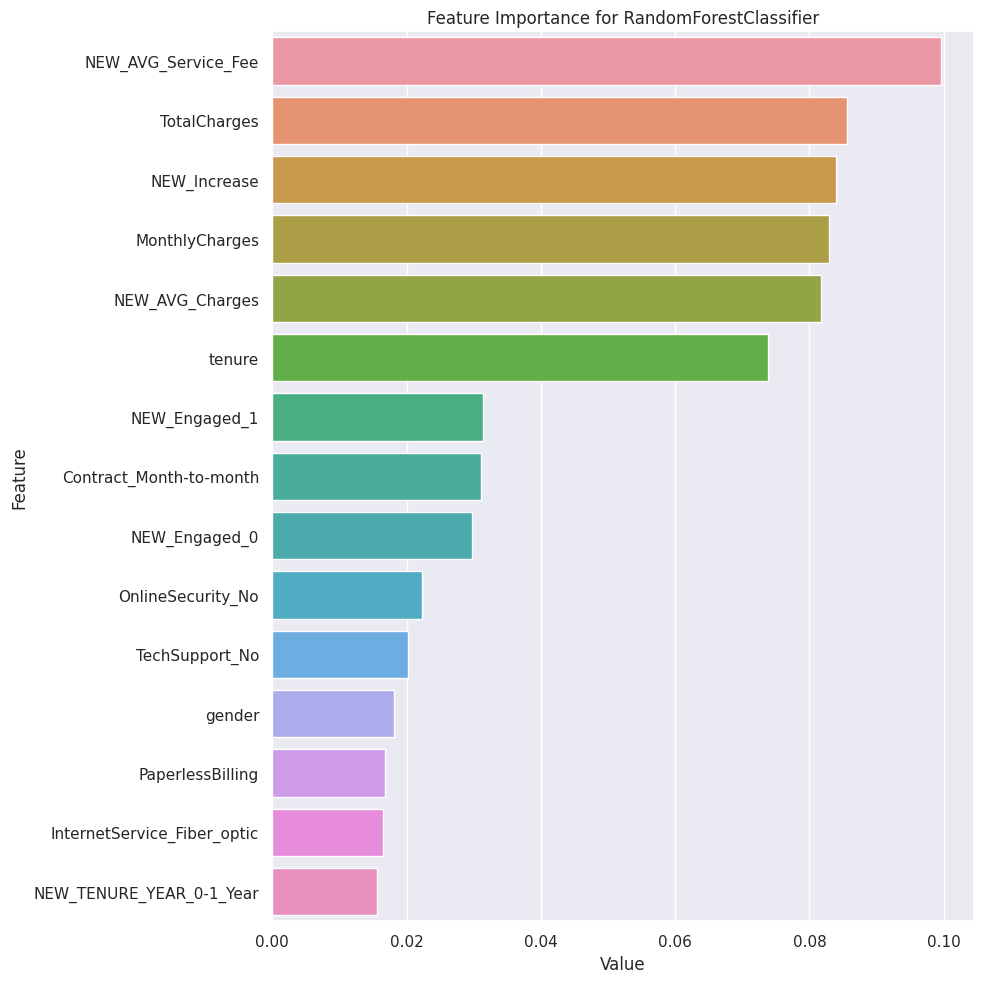

Feature Importance for XGB:


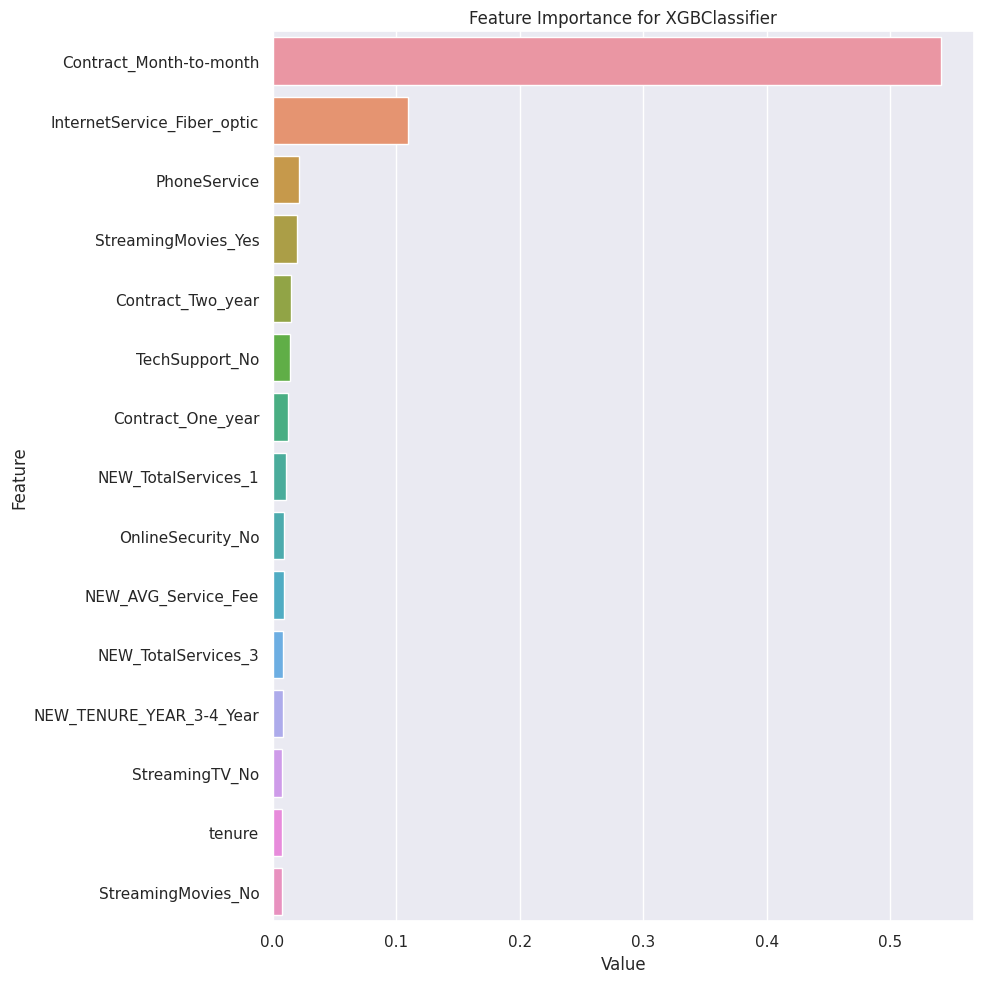

Feature Importance for LightGBM:


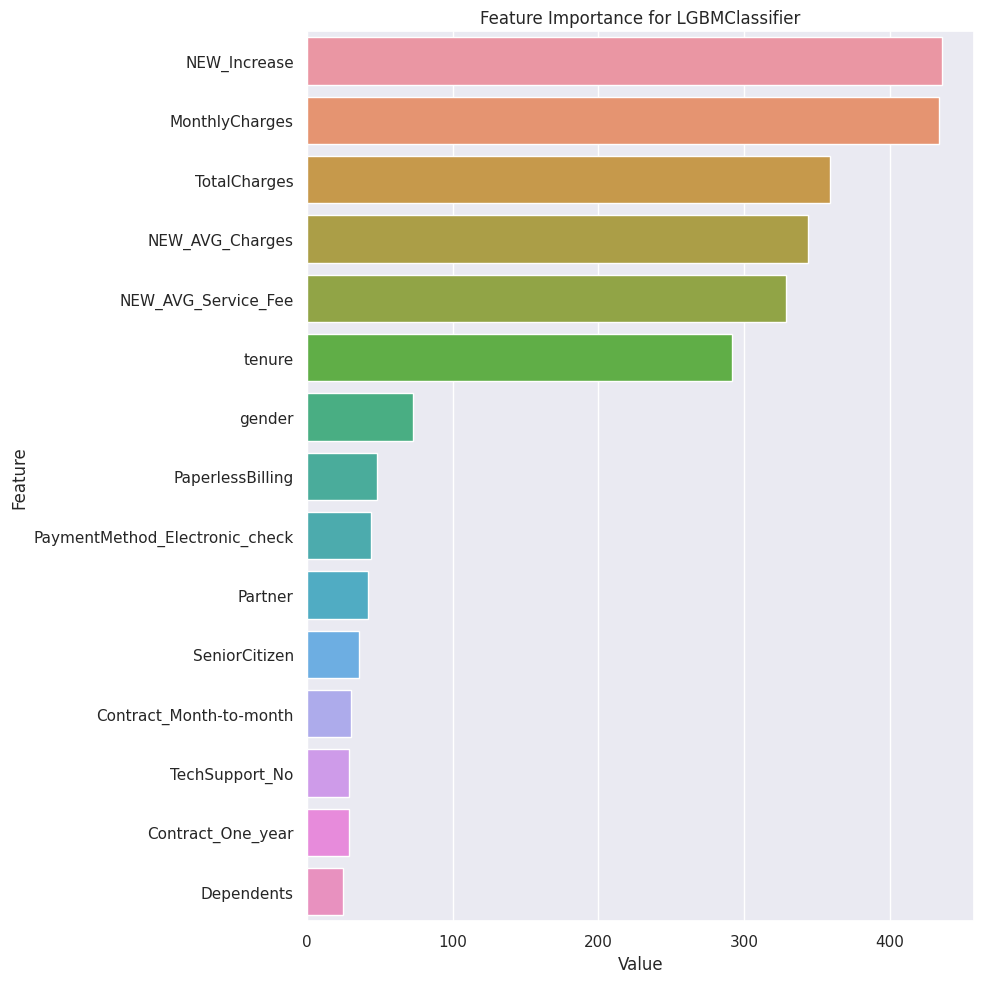

Feature Importance for CatBoost:


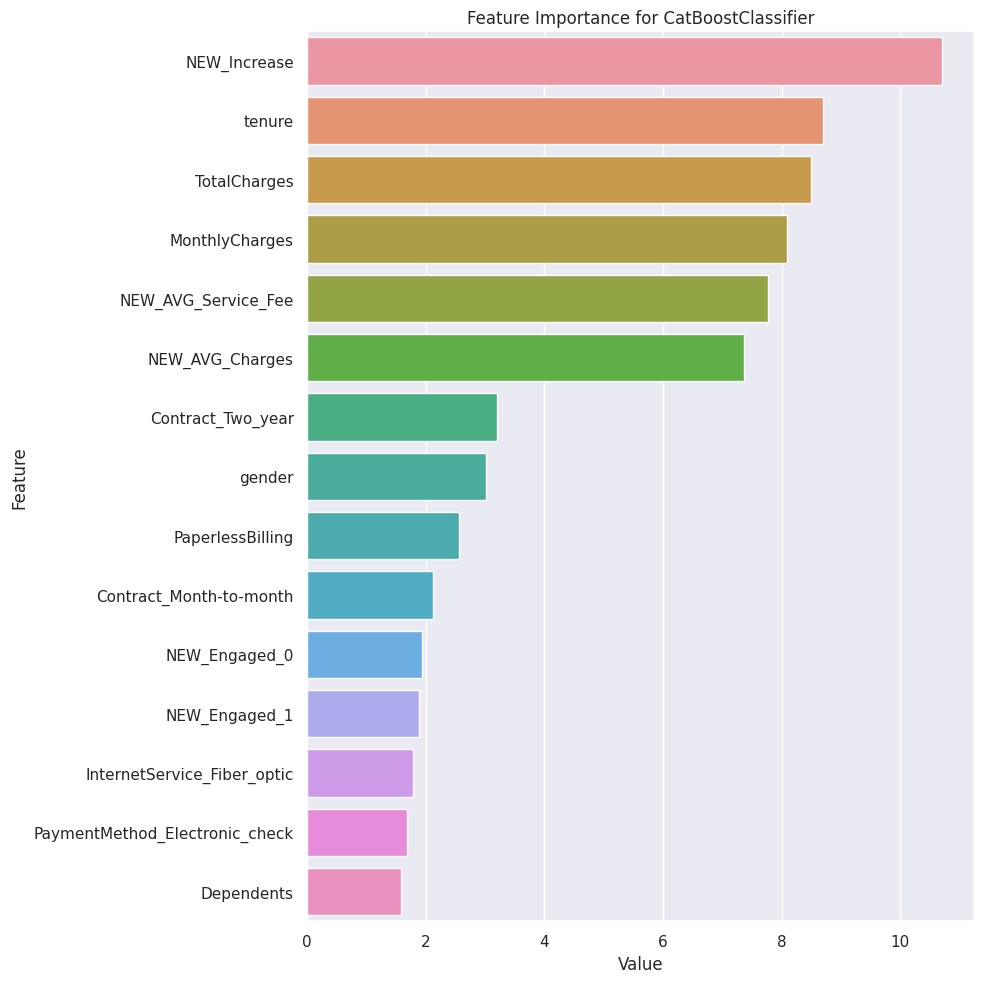

In [55]:
# Function to plot the feature importance
def plot_importance(model, features, num=len(X_train.columns), save=False):
    if hasattr(model, 'feature_importances_'):  # checking to see if the model supports feature importance
        feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
        plt.title(f'Feature Importance for {type(model).__name__}')
        plt.tight_layout()
        plt.show()
        if save:
            plt.savefig(f'{type(model).__name__}_importances.png')
    else:
        print(f"{type(model).__name__} does not have feature_importances_ attribute")

# looping over the models
for model_name, model in models:
    # ploting the grap only for the models that supports feature importance
    print(f"Feature Importance for {model_name}:")
    plot_importance(model, X_train, num=15)


In [56]:
best_models = result_new_df.sort_values(by="F1 Score", ascending=False)
best_models

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,LR,0.807,0.700,0.519,0.596,0.861
6,CatBoost,0.799,0.682,0.504,0.579,0.854
4,XGB,0.791,0.650,0.522,0.579,0.841
5,LightGBM,0.795,0.666,0.509,0.577,0.846
3,RF,0.791,0.653,0.506,0.571,0.834
1,KNN,0.762,0.573,0.519,0.545,0.791
2,CART,0.742,0.529,0.543,0.536,0.684


<div style="text-align: center; font-size: 18px; font-weight: bold; color: purple;">
     Model Optimisation
</div>

In [57]:
results_opt_ = []

# dictinioray for hyperparameters of each model 
param_grids = {
    'LR': {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs'], 'class_weight': ['balanced']},
    'KNN': {'n_neighbors': range(3, 15), 'weights': ['uniform', 'distance']},
    'CART': {'max_depth': [5, 10, 20, 30], 'min_samples_split': [10, 12, 15, 17], 'min_samples_leaf': [5, 10, 15]},
    'RF': {'n_estimators': [100, 150, 200], 'max_depth': [5, 10, 14, None], 'bootstrap': [True], 'max_features': ['sqrt', 5, 7], 'min_samples_split': [5, 8], 'max_samples': [0.7, None], 'class_weight': ['balanced']},
    'XGB': {'n_estimators': [100, 200, 300], 'learning_rate': [0.001, 0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]},
    'LightGBM': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'num_leaves': [31, 50, 150]},
    'CatBoost': {'iterations': [100, 200], 'learning_rate': [0.001, 0.01, 0.05, 0.1], 'depth': [4, 6]}
}

# Model names and the objects 
models = [('LR', LogisticRegression(random_state=24689, max_iter=8000)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=24689)),
          ('RF', RandomForestClassifier(random_state=24689)),
          ('XGB', XGBClassifier(random_state=24689)),
          ("LightGBM", LGBMClassifier(random_state=24689, force_row_wise=True, verbose=-1)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=24689))]

for model_name, model in models:
    print(f"Model: {model_name}")

    # creating the hyperparameter grid 
    param_grid = param_grids.get(model_name, {}) 

    # identifying the best parameters with GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=10, n_jobs=-1, verbose=0)

    # Training the model on the train set
    grid_search.fit(X_train, y_train)

    # predictions on the Test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

    # calculating the metrics 
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # getting the best parameters 
    best_params = grid_search.best_params_

    # storing the results 
    results_opt_.append({
        'Model': model_name,
        'Best_Params': best_params,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'AUC': auc
    })

Model: LR
Model: KNN
Model: CART
Model: RF
Model: XGB
Model: LightGBM
Model: CatBoost


In [58]:
#converting the results to a dataframe
import pandas as pd
result_new_df_ = pd.DataFrame(results_opt_)
result_new_df_

,Model,Best_Params,Accuracy,Precision,Recall,F1_Score,AUC
0,LR,"{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}",0.763,0.546,0.811,0.653,0.861
1,KNN,"{'n_neighbors': 11, 'weights': 'uniform'}",0.782,0.621,0.530,0.572,0.822
2,CART,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}",0.770,0.584,0.566,0.575,0.827
3,RF,"{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 5, 'max_samples': None, 'min_samples_split': 5, 'n_estimators': 100}",0.781,0.581,0.734,0.648,0.853
4,XGB,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}",0.805,0.701,0.504,0.586,0.857
5,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}",0.795,0.666,0.509,0.577,0.846
6,CatBoost,"{'depth': 4, 'iterations': 100, 'learning_rate': 0.1}",0.801,0.691,0.496,0.577,0.857


In [59]:
#sorting the values by f1_score
best_models_opt = result_new_df_.sort_values(by="F1_Score", ascending=False)
best_models_opt

,Model,Best_Params,Accuracy,Precision,Recall,F1_Score,AUC
0,LR,"{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}",0.763,0.546,0.811,0.653,0.861
3,RF,"{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 5, 'max_samples': None, 'min_samples_split': 5, 'n_estimators': 100}",0.781,0.581,0.734,0.648,0.853
4,XGB,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}",0.805,0.701,0.504,0.586,0.857
6,CatBoost,"{'depth': 4, 'iterations': 100, 'learning_rate': 0.1}",0.801,0.691,0.496,0.577,0.857
5,LightGBM,"{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}",0.795,0.666,0.509,0.577,0.846
2,CART,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}",0.770,0.584,0.566,0.575,0.827
1,KNN,"{'n_neighbors': 11, 'weights': 'uniform'}",0.782,0.621,0.530,0.572,0.822


In [60]:
#comparing the results
comparison_results = best_models.merge(best_models_opt, on='Model', suffixes=('_Before', '_After'))
comparison_results

,Model,Accuracy_Before,Precision_Before,Recall_Before,F1 Score,AUC_Before,Best_Params,Accuracy_After,Precision_After,Recall_After,F1_Score,AUC_After
0,LR,0.807,0.700,0.519,0.596,0.861,"{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}",0.763,0.546,0.811,0.653,0.861
1,CatBoost,0.799,0.682,0.504,0.579,0.854,"{'depth': 4, 'iterations': 100, 'learning_rate': 0.1}",0.801,0.691,0.496,0.577,0.857
2,XGB,0.791,0.650,0.522,0.579,0.841,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}",0.805,0.701,0.504,0.586,0.857
3,LightGBM,0.795,0.666,0.509,0.577,0.846,"{'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}",0.795,0.666,0.509,0.577,0.846
4,RF,0.791,0.653,0.506,0.571,0.834,"{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 5, 'max_samples': None, 'min_samples_split': 5, 'n_estimators': 100}",0.781,0.581,0.734,0.648,0.853
5,KNN,0.762,0.573,0.519,0.545,0.791,"{'n_neighbors': 11, 'weights': 'uniform'}",0.782,0.621,0.530,0.572,0.822
6,CART,0.742,0.529,0.543,0.536,0.684,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}",0.770,0.584,0.566,0.575,0.827


**Conslusion;**
Since the target variable 'Churn" has imbalanced distribution, "Accuracy' itself not a good indicater of success of the model. We should focus on F1 Score as it is harmonic mean of both Precision and Recall.

The Logisctic Regression model with {'C': 0.01, 'class_weight': 'balanced', 'solver': 'liblinear'} has the highest F1 score (0.654) and also a strong recall (0.822).

However, its precision (0.544) is slightly lower, indicating that a larger portion of the predicted churners may not actually churn.

<div style="text-align: center; font-size: 18px; font-weight: bold; color: purple;">
     Final Model - Logistic Regression
</div>

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_auc_score

# Define your best hyperparameters (these should come from your optimization step)
best_params = {
    'max_depth': 7,
    'min_samples_split': 5,
    'n_estimators': 500,
    'bootstrap': True,
    'max_features': 5,
    'class_weight': 'balanced',
    'max_samples': None,
    'random_state': 24
}

# Train the final model on the entire dataset with the best parameters
rf_final = RandomForestClassifier(**best_params).fit(X, y)

# Evaluate the model using cross-validation
cv_results = cross_validate(
    rf_final, X, y, cv=10,
    scoring={
        "accuracy": "accuracy",
        "f1": "f1_weighted",
        "recall": "recall_weighted",
        "precision": "precision_weighted",
        "roc_auc": make_scorer(roc_auc_score, needs_proba=True)
    }
)

# Print the cross-validation results
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"F1 Score: {cv_results['test_f1'].mean():.4f}")
print(f"Recall: {cv_results['test_recall'].mean():.4f}")
print(f"Precision: {cv_results['test_precision'].mean():.4f}")
print(f"AUC: {cv_results['test_roc_auc'].mean():.4f}")


Accuracy: 0.7522
F1 Score: 0.7650
Recall: 0.7522
Precision: 0.8066
AUC: 0.8455


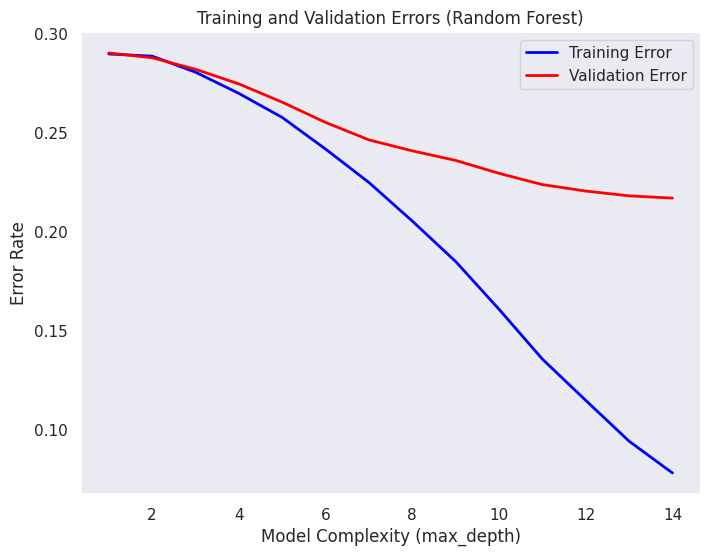

In [62]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Define Random Forest model with the best hyperparameters
model = RandomForestClassifier(**best_params)

# Define the parameter range for 'max_depth'
param_range = range(1, 15)

# Calculate the training and test scores for Validation Curve
train_scores, test_scores = validation_curve(
    model, X, y,
    param_name='max_depth', param_range=param_range,
    scoring="accuracy", cv=5, n_jobs=-1)

# Calculate the mean training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Calculate the training and validation errors
train_errors = 1 - train_scores_mean
validation_errors = 1 - test_scores_mean

# Plotting the training and validation errors
plt.figure(figsize=(8, 6))
plt.plot(param_range, train_errors, label="Training Error", color='blue', lw=2)
plt.plot(param_range, validation_errors, label="Validation Error", color='red', lw=2)

# Graphic Settings
plt.title('Training and Validation Errors (Random Forest)')
plt.xlabel('Model Complexity (max_depth)')
plt.ylabel('Error Rate')
plt.legend(loc="upper right")
plt.grid()

# Display the graph
plt.show()

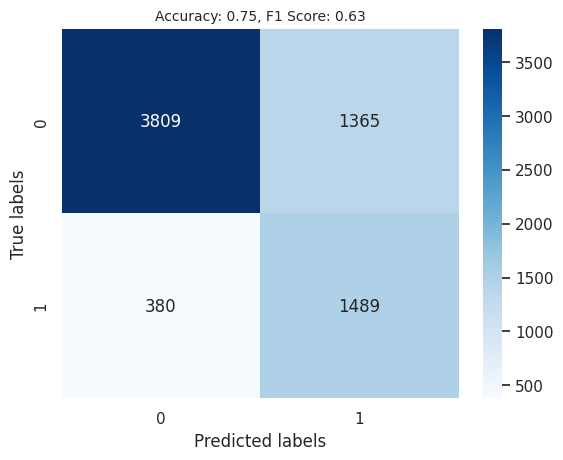

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.74      0.81      5174
           1       0.52      0.80      0.63      1869

    accuracy                           0.75      7043
   macro avg       0.72      0.77      0.72      7043
weighted avg       0.81      0.75      0.77      7043



In [63]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    acc = round(accuracy_score(y_true, y_pred), 2)
    f1 = round(f1_score(y_true, y_pred), 2)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Accuracy: {0}, F1 Score: {1}'.format(acc, f1), size=10)
    plt.show()


# Generate cross-validated predictions for the entire dataset
y_pred_cv = cross_val_predict(rf_final, X, y, cv=10, method='predict')

# Plot the confusion matrix with cross-validated predictions
plot_confusion_matrix(y, y_pred_cv)

# Print the classification report
print("Classification Report:\n", classification_report(y, y_pred_cv))

**True Negatives (TN): 3809**
The number of customers who did not churn (0) and were correctly predicted as not churning. (Negatives that the model correctly predicted)

**False Positives (FP): 1365**
The number of customers who did not churn (0) but were incorrectly predicted as churning (1). (The model's false positive predictions) - The company may take unnecessary retention actions, such as offering discounts or special deals to these customers, which could incur additional costs without necessity.

**False Negatives (FN): 380**
The number of customers who did churn (1) but were incorrectly predicted as not churning (0). (The model's false negative predictions) - The company misses the opportunity to take retention actions, resulting in the loss of customers who actually end up leaving. ***This can be more damaging because each lost customer represents a loss of potential revenue.

**True Positives (TP): 1489**
The number of customers who did churn (1) and were correctly predicted as churning. (The model's true positive predictions)


**Conclusion;**
False Negatives need to be reduced to minimize churn as much as possible.

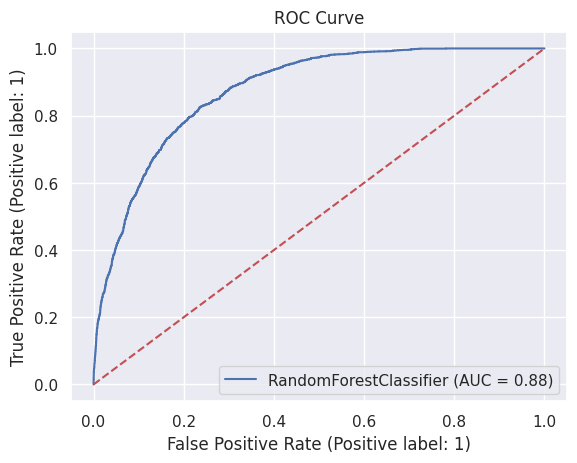

In [64]:
RocCurveDisplay.from_estimator(rf_final, X, y)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

**ROC Curve;**
True Positive Rate (TPR), also known as recall, is on the y-axis. It represents the proportion of actual positives (churn) that the model correctly identified.

False Positive Rate (FPR) is on the x-axis. It represents the proportion of actual negatives (non-churn) that the model incorrectly identified as positive.

The blue line represents the ROC curve for the Logistic Regression model. A perfect classifier would have a curve that hugs the top-left corner.

The red dashed line represents a random classifier. If the ROC curve were close to this line, it would indicate poor model performance.

The AUC (Area Under the Curve) value of 0.91 is displayed. An AUC score ranges from 0.5 (random guessing) to 1 (perfect classification). Normally, the closer the AUC is to 1, the better the model is at distinguishing between positive and negative classes. However, AUC alone may not be sufficient to determine the model's success. Other metrics expecially F1 should also be considered.

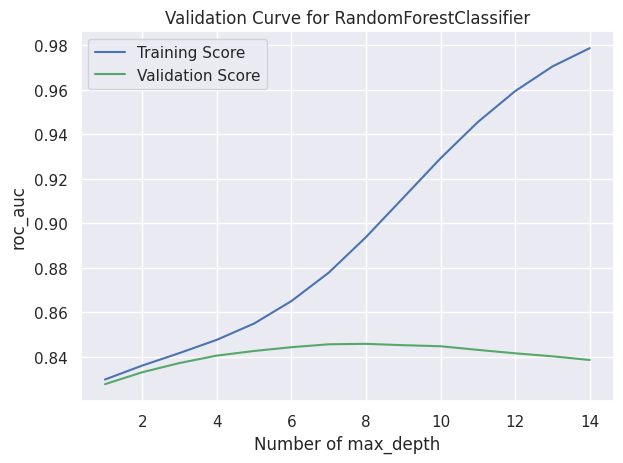

In [65]:
#Learning Curve
def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

val_curve_params(rf_final, X, y, "max_depth", range(1, 15), scoring="roc_auc")

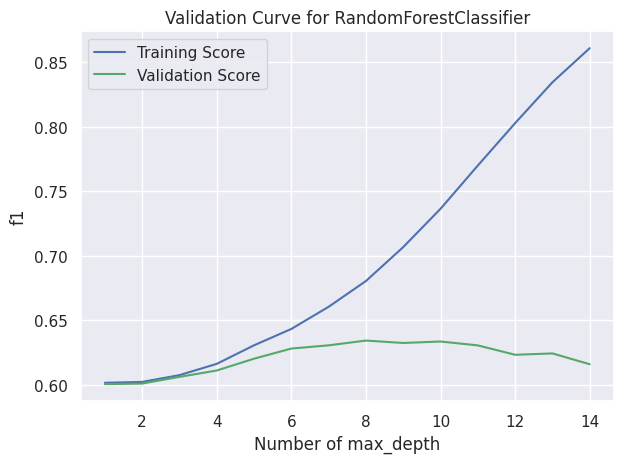

In [66]:
# Learning Curve Function
def val_curve_params(model, X, y, param_name, param_range, scoring="f1", cv=10):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    # Calculate mean scores across cross-validation folds
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    # Plotting the training and validation scores
    plt.plot(param_range, mean_train_score, label="Training Score", color='b')
    plt.plot(param_range, mean_test_score, label="Validation Score", color='g')

    # Add title and labels
    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

# Example: Plotting the validation curve for F1 score with RandomForest and 'max_depth'
val_curve_params(rf_final, X, y, "max_depth", range(1, 15), scoring="f1")

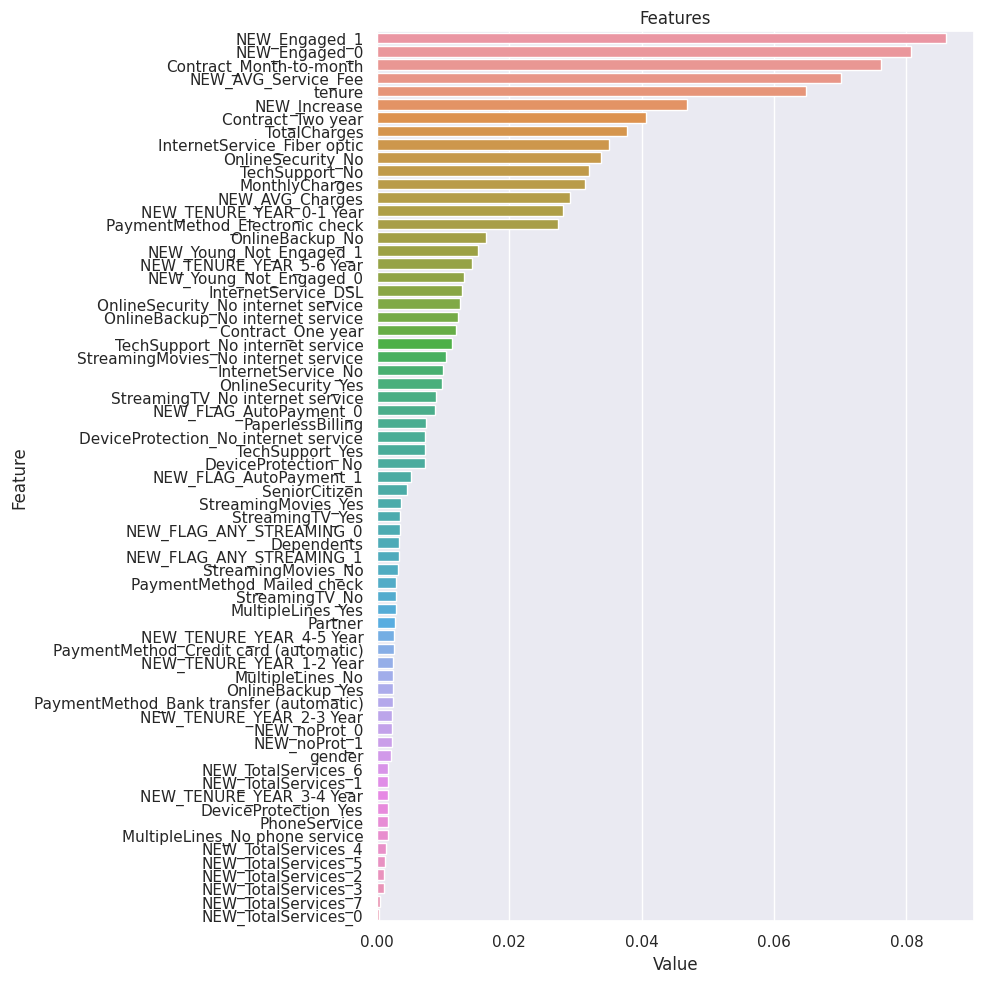

In [67]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_final, X)

<div style="text-align: center; font-size: 18px; font-weight: bold; color: purple;">
     Final Conclusion 
</div>

* The model's performance can be improved with more feature engineering. 
* Hyperparameter optimization can be performed to enhance the model’s performance (particularly focusing on metrics that better capture churn). 
* The model has reached a certain level of success, but it can be further improved by focusing on methods that minimize missed churn customers such as SMOTE (Synthetic Minority Over-sampling Technique), increasing the data, lowering the threashold (but this might increase False Positives (FP). so there is a trade-off to consider.